# Bibliotecas 


In [1]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 #instalando Pytorch com suporte a GPU
#testando a instalacao 
#import torch
#print(torch.__version__)  # Deve exibir a versão do PyTorch instalada
#print(torch.cuda.is_available())  # Deve retornar True se a GPU estiver funcionando
#print(torch.cuda.get_device_name())  # Deve exibir 'NVIDIA GeForce RTX 2050'


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, 
    f1_score, accuracy_score, roc_curve, auc, make_scorer
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from optuna.samplers import TPESampler
import logging
import warnings
from torch.optim import lr_scheduler
from joblib import Parallel, delayed
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif




########################### para KAGGLE ################################################################################################################
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
########################################################################################################################################################

C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dicinário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Points Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


#  Análise Exploratória (EDA) & Data Prep


In [3]:
# base de dados
# base_original = pd.read_csv('/kaggle/input/Customer-Churn-Records.csv', sep=',') #KAGGLE
base_original = pd.read_csv('C:/Users/jgeov/iCloudDrive/Treinamento/Treinamento Data Science/Projetos/Customer-Churn-Records.csv',sep=',') #LOCAL

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)

#primeiras linhas 
base_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [4]:
#Dimensões da base de dados
print("Numero de linhas:", base_original.shape[0]) 
print("Numero de colunas:", base_original.shape[1])

Numero de linhas: 10000
Numero de colunas: 18


In [5]:
#Verificando tipos dados originais 
base_original.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

In [6]:
#checando se há valores nulos 
base_original.isnull().sum()  
#valores nulos nao encontrados 

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [7]:
# Resumo estatistico da base original
base_original.describe()


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


In [8]:
#Limpando variavéis que não tem interferencia na analise, sao meramente
#identificadoras: RowNumber, CustomerId e Surname

df = base_original[['CreditScore',
                    'Gender',
                    'Geography',
                    'Age','Tenure',
                    'Balance',
                   'NumOfProducts',
                    'HasCrCard',
                    'IsActiveMember',
                   'EstimatedSalary',
                    'Complain',
                    'Satisfaction Score',
                   'Card Type',
                    'Point Earned',
                    'Exited'
                   ]]

# Resumo estatístico das variáveis quantitativas
quanti = df[['EstimatedSalary', 'Balance', 'CreditScore', 'Age', 'Tenure', 'Point Earned']]
resumo_estati_quant = quanti.describe().style.format(lambda x: f'{x:,.1f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) # Formatação com 1 casa decimal e separadores invertidos

resumo_estati_quant

,EstimatedSalary,Balance,CreditScore,Age,Tenure,Point Earned
count,"10.000,0","10.000,0","10.000,0","10.000,0","10.000,0","10.000,0"
mean,"100.090,2","76.485,9","650,5","38,9","5,0","606,5"
std,"57.510,5","62.397,4","96,7","10,5","2,9","225,9"
min,"11,6","0,0","350,0","18,0","0,0","119,0"
25%,"51.002,1","0,0","584,0","32,0","3,0","410,0"
50%,"100.193,9","97.198,5","652,0","37,0","5,0","605,0"
75%,"149.388,2","127.644,2","718,0","44,0","7,0","801,0"
max,"199.992,5","250.898,1","850,0","92,0","10,0","1.000,0"


In [9]:
#%% Resumo estatistico das varaiveis Quali ("tabelas" de frequencias)

quali = df[['HasCrCard', 'IsActiveMember', 'Geography','Gender'
            ,'Complain','Exited','Card Type']]

quali = quali.astype('object')

print("------------------------------------------")
print(quali['HasCrCard'].value_counts())
print("------------------------------------------")
print(quali['IsActiveMember'].value_counts())
print("------------------------------------------")
print(quali['Geography'].value_counts())
print("------------------------------------------")
print(quali['Gender'].value_counts())
print("------------------------------------------")
print(quali['Complain'].value_counts())
print("------------------------------------------")
print(quali['Card Type'].value_counts())
print("------------------------------------------")
print(quali['Exited'].value_counts())
print("------------------------------------------")

------------------------------------------
HasCrCard
1    7055
0    2945
Name: count, dtype: int64
------------------------------------------
IsActiveMember
1    5151
0    4849
Name: count, dtype: int64
------------------------------------------
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
------------------------------------------
Gender
Male      5457
Female    4543
Name: count, dtype: int64
------------------------------------------
Complain
0    7956
1    2044
Name: count, dtype: int64
------------------------------------------
Card Type
DIAMOND     2507
GOLD        2502
SILVER      2496
PLATINUM    2495
Name: count, dtype: int64
------------------------------------------
Exited
0    7962
1    2038
Name: count, dtype: int64
------------------------------------------


In [10]:
# Verificando tipos das variaveis quali (para morrer de certeza) 
quali.dtypes

HasCrCard         object
IsActiveMember    object
Geography         object
Gender            object
Complain          object
Exited            object
Card Type         object
dtype: object

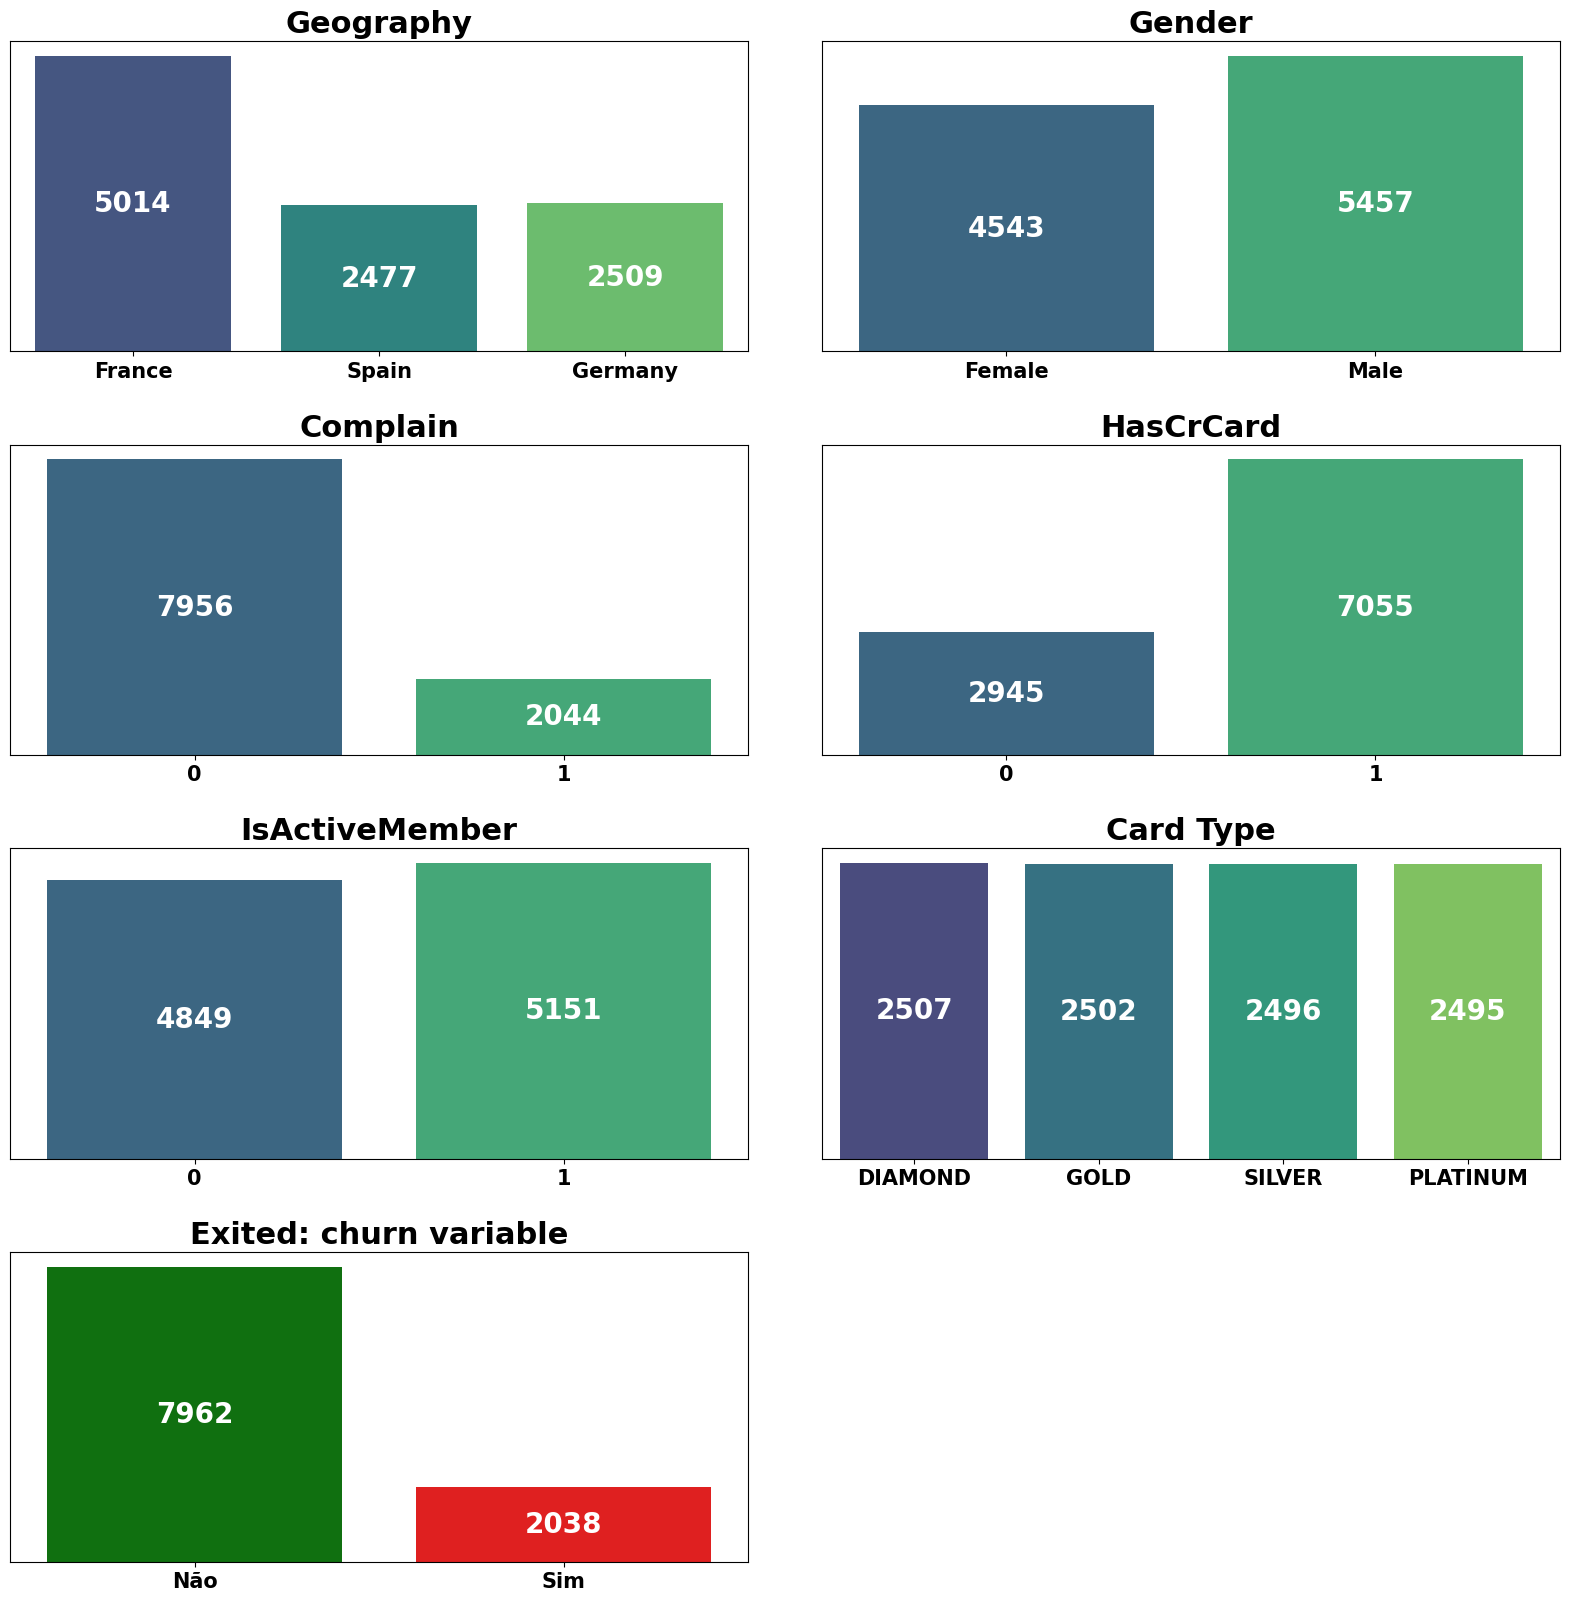

In [11]:
# Visualizando Frequencia das variaveis categoricas 

def add_value_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        color = p.get_facecolor()
        ax.text(p.get_x() + p.get_width() / 2., height / 2.,
                f'{int(height)}',
                ha='center', va='center', fontsize=20, color='white', fontweight='bold',
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,
                          boxstyle='round,pad=0.4', linewidth=1))

plt.figure(figsize=(20, 25))

# Geography
plt.subplot(5, 2, 1)
ax1 = plt.gca()
ax1.set_title('Geography', fontsize=22, fontweight='bold')
sns.countplot(x='Geography', hue='Geography', palette='viridis', data=base_original, ax=ax1, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax1)

# Gender
plt.subplot(5, 2, 2)
ax2 = plt.gca()
ax2.set_title('Gender', fontsize=22, fontweight='bold')
sns.countplot(x='Gender', hue='Gender', palette='viridis', data=base_original, ax=ax2, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax2)

# Complain
plt.subplot(5, 2, 3)
ax10 = plt.gca()
ax10.set_title('Complain', fontsize=22, fontweight='bold')
sns.countplot(x='Complain', hue='Complain', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# HasCrCard
plt.subplot(5, 2, 4)
ax5 = plt.gca()
ax5.set_title('HasCrCard', fontsize=22, fontweight='bold')
sns.countplot(x='HasCrCard', hue='HasCrCard', palette='viridis', data=base_original, ax=ax5, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax5)

# IsActiveMember
plt.subplot(5, 2, 5)
ax6 = plt.gca()
ax6.set_title('IsActiveMember', fontsize=22, fontweight='bold')
sns.countplot(x='IsActiveMember', hue='IsActiveMember', palette='viridis', data=base_original, ax=ax6, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax6)

# Card Type
plt.subplot(5, 2, 6)
ax10 = plt.gca()
ax10.set_title('Card Type', fontsize=22, fontweight='bold')
sns.countplot(x='Card Type', hue='Card Type', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# Exited
plt.subplot(5, 2, 7)
ax7 = plt.gca()
ax7.set_title('Exited: churn variable', fontsize=22, fontweight='bold')
custom_palette = ['green', 'red']
sns.countplot(x='Exited', hue='Exited', palette=custom_palette, data=base_original, ax=ax7, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax7)

ax7.set_xticks([0, 1])
ax7.set_xticklabels(['Não', 'Sim'], fontsize=15, fontweight='bold')

# Ajustando espaçamento
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.show()




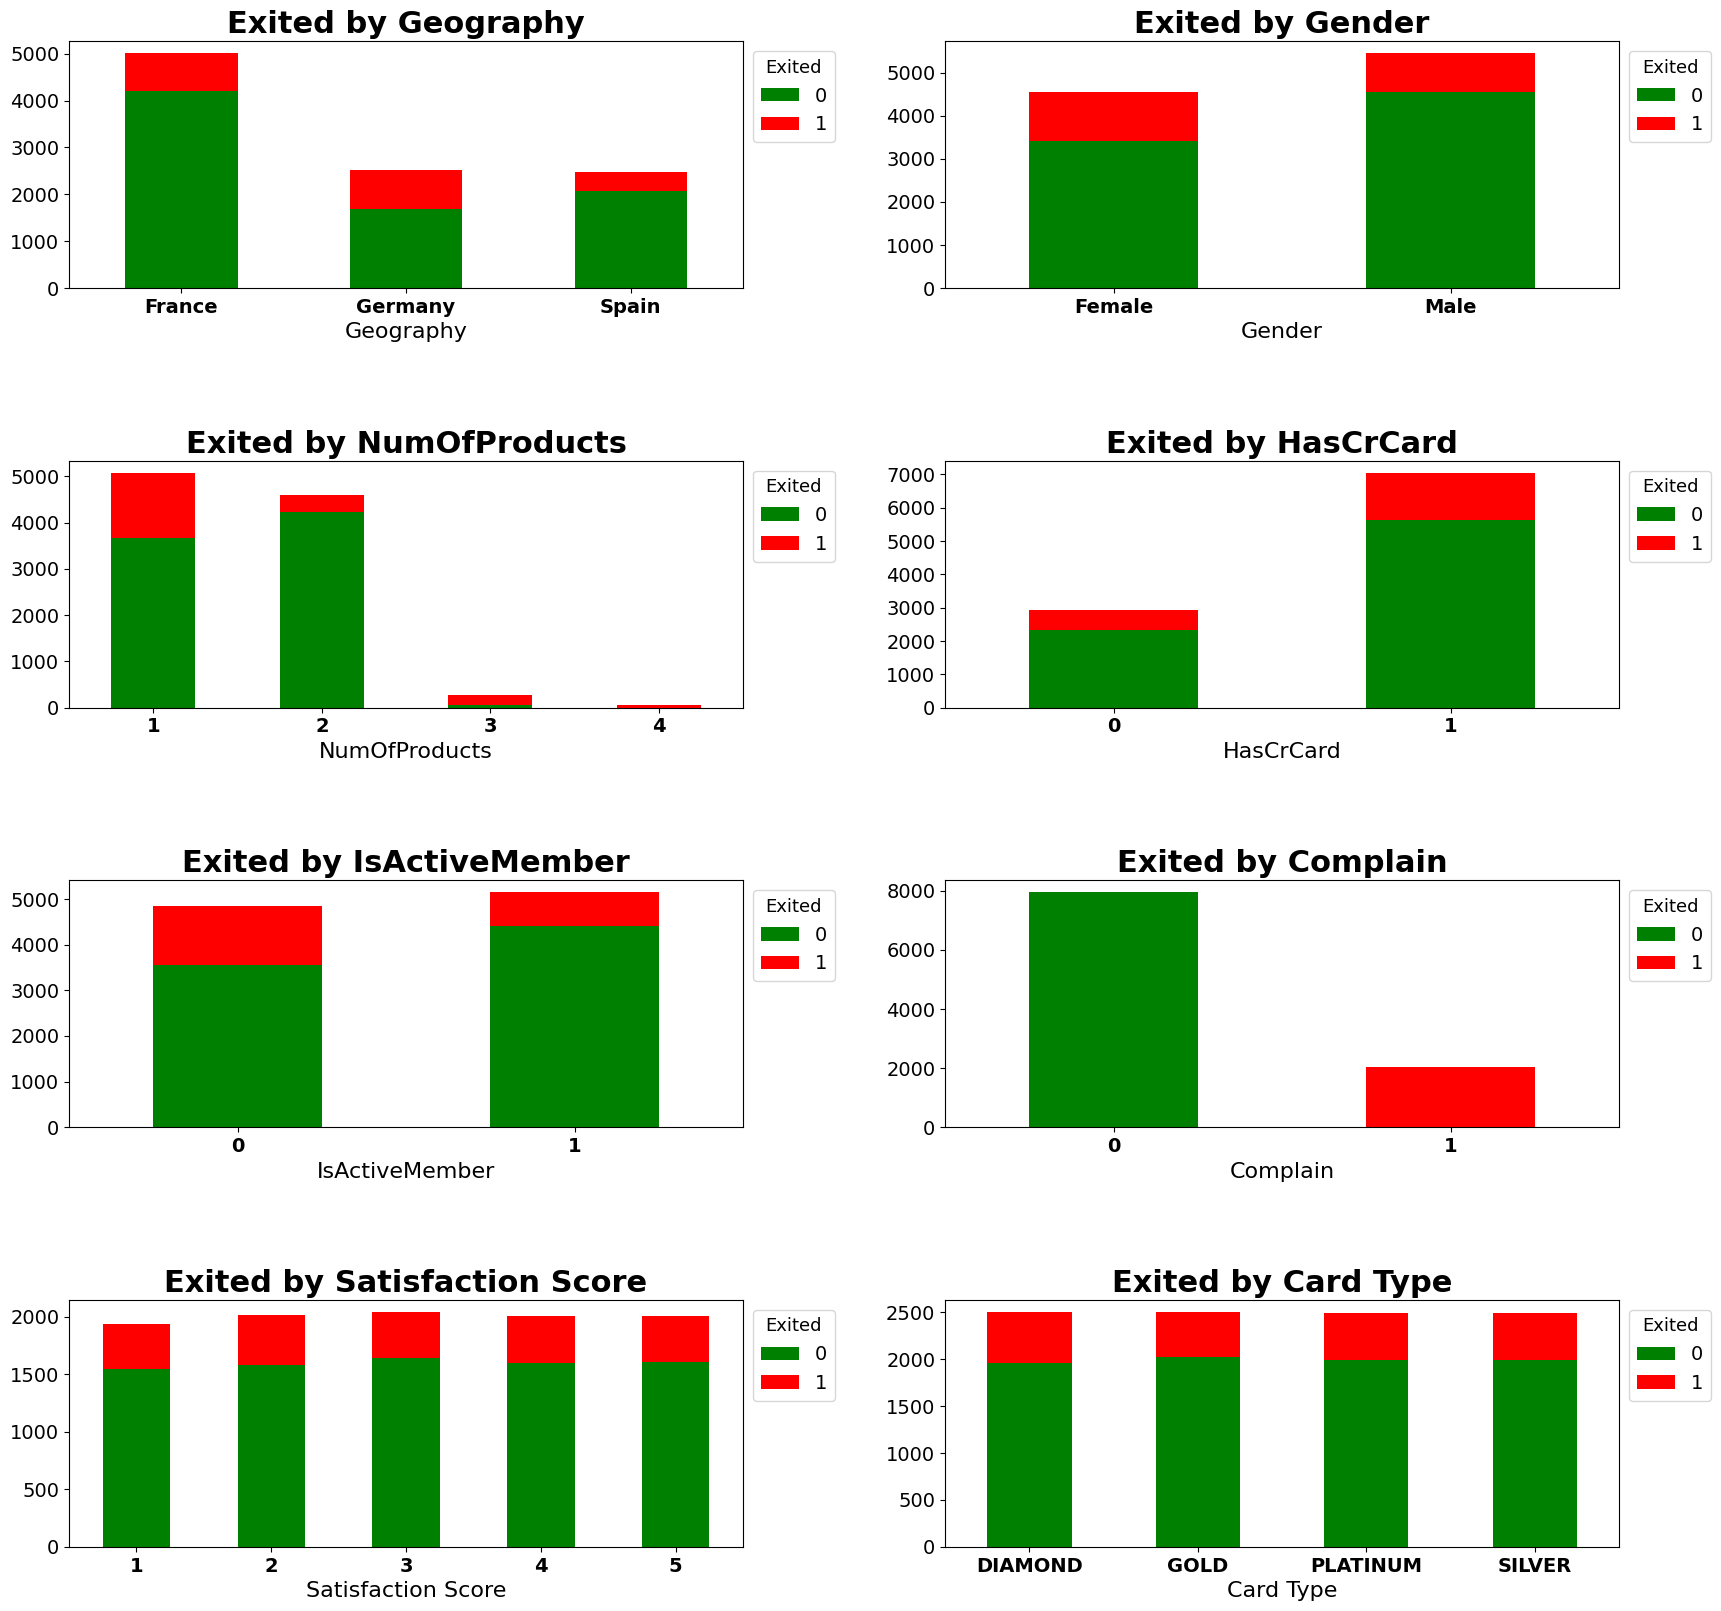

In [12]:
#%% Visualizando a Variável alvo em relação as demais variáveis 

plt.figure(figsize=(20, 25)) #tamanho do painel grafico

#funcao de adicao de legenda no canto superior direito e garante rotulos 
def add_legend(ax):
    
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        
        # Se não houver handles, forca a adicao
        handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']
        
    # Adiciona a legenda fora da área das barras
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',  
              bbox_to_anchor=(1.0, 1)) 

# Geography
plt.subplot(5, 2, 1)
counts = base_original.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Geography', fontsize=22, fontweight='bold')
plt.xlabel('Geography', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Gender
plt.subplot(5, 2, 2)
counts = base_original.groupby(['Gender', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by Gender', fontsize=22, fontweight='bold')
plt.xlabel('Gender', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# NumOfProducts
plt.subplot(5, 2, 3)
counts = base_original.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by NumOfProducts', fontsize=22, fontweight='bold')
plt.xlabel('NumOfProducts', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# HasCrCard
plt.subplot(5, 2, 4)
counts = base_original.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by HasCrCard', fontsize=22, fontweight='bold')
plt.xlabel('HasCrCard', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# IsActiveMember
plt.subplot(5, 2, 5)
counts = base_original.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by IsActiveMember', fontsize=22, fontweight='bold')
plt.xlabel('IsActiveMember', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Complain
plt.subplot(5, 2, 6)
counts = base_original.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Complain', fontsize=22, fontweight='bold')
plt.xlabel('Complain', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Satisfaction Score
plt.subplot(5, 2, 7)
counts = base_original.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Satisfaction Score', fontsize=22, fontweight='bold')
plt.xlabel('Satisfaction Score', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Card Type
plt.subplot(5, 2, 8)
counts = base_original.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Card Type', fontsize=22, fontweight='bold')
plt.xlabel('Card Type', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Ajustar a distância entre os gráficos
plt.subplots_adjust(hspace=0.7, wspace=0.3)

# Variaveis Dummies e Correlações 

In [13]:
# Dumizando

# Suprime todos os warnings de futuro (deixa mais clean) 
warnings.filterwarnings('ignore', category=FutureWarning)



# Lista de colunas a serem transformadas
cols_to_transform = ['HasCrCard', 'IsActiveMember', 'Geography', 'Gender', 'Card Type']

# Convertendo para string
df.loc[:, cols_to_transform] = df.loc[:, cols_to_transform].astype(str)

# one-hot encoding 
df_dummies = pd.get_dummies(df, columns=cols_to_transform, dtype=int, drop_first=False)

# variável alvo 'Exited' para o tipo numérico
df_dummies['Exited'] = df_dummies['Exited'].astype('int64')

print(df_dummies.dtypes)

CreditScore             int64
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
EstimatedSalary       float64
Complain                int64
Satisfaction Score      int64
Point Earned            int64
Exited                  int64
HasCrCard_0             int64
HasCrCard_1             int64
IsActiveMember_0        int64
IsActiveMember_1        int64
Geography_France        int64
Geography_Germany       int64
Geography_Spain         int64
Gender_Female           int64
Gender_Male             int64
Card Type_DIAMOND       int64
Card Type_GOLD          int64
Card Type_PLATINUM      int64
Card Type_SILVER        int64
dtype: object


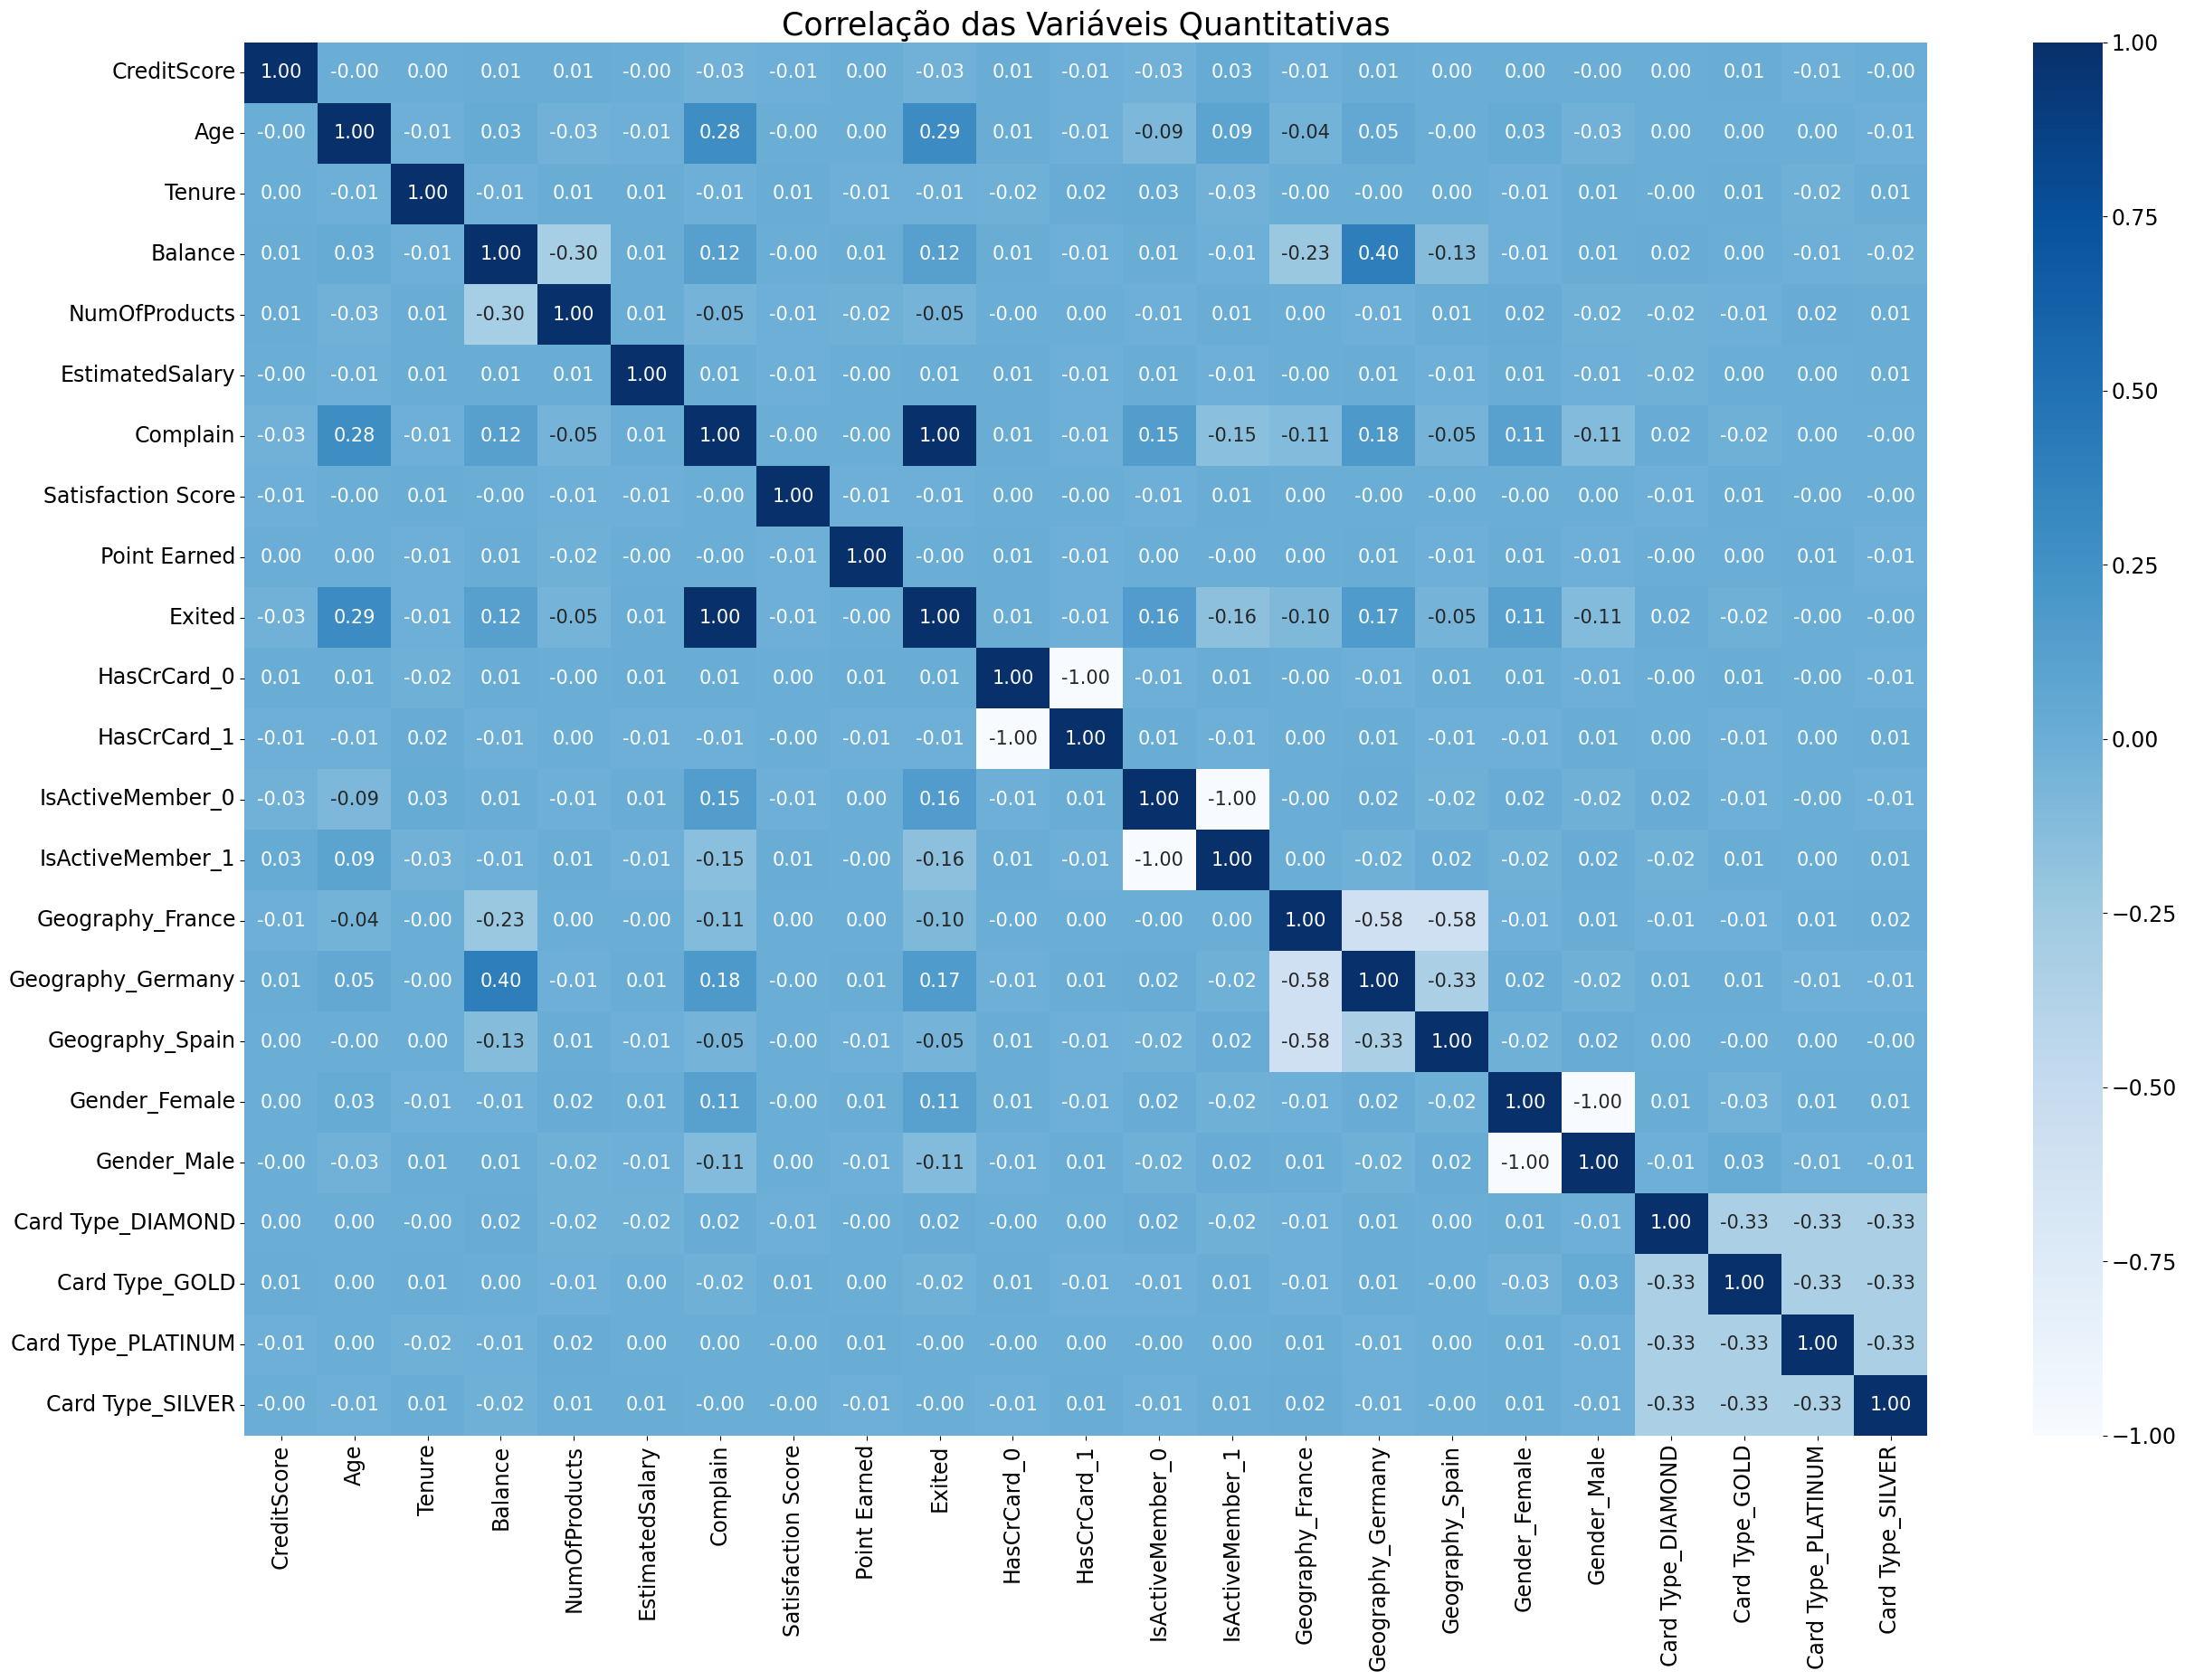

In [14]:
#Correlação das variaveis Numéricas 

# Matrix com Mapa de calor 
correlation_matrix = df_dummies.corr().round(2)
correlation_matrix

plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
                      cmap=plt.cm.Blues,
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.title('Correlação das Variáveis Quantitativas', fontsize=25)
plt.show()



# As variaveis a seguir apresentaram correlacao alta, para evitar multicolinearidade foram removidas 
df_dummies = df_dummies.drop(columns=['HasCrCard_0','IsActiveMember_0','Gender_Female','Complain'])

# Separação Treino e Teste & Adicao de Features quadráticas

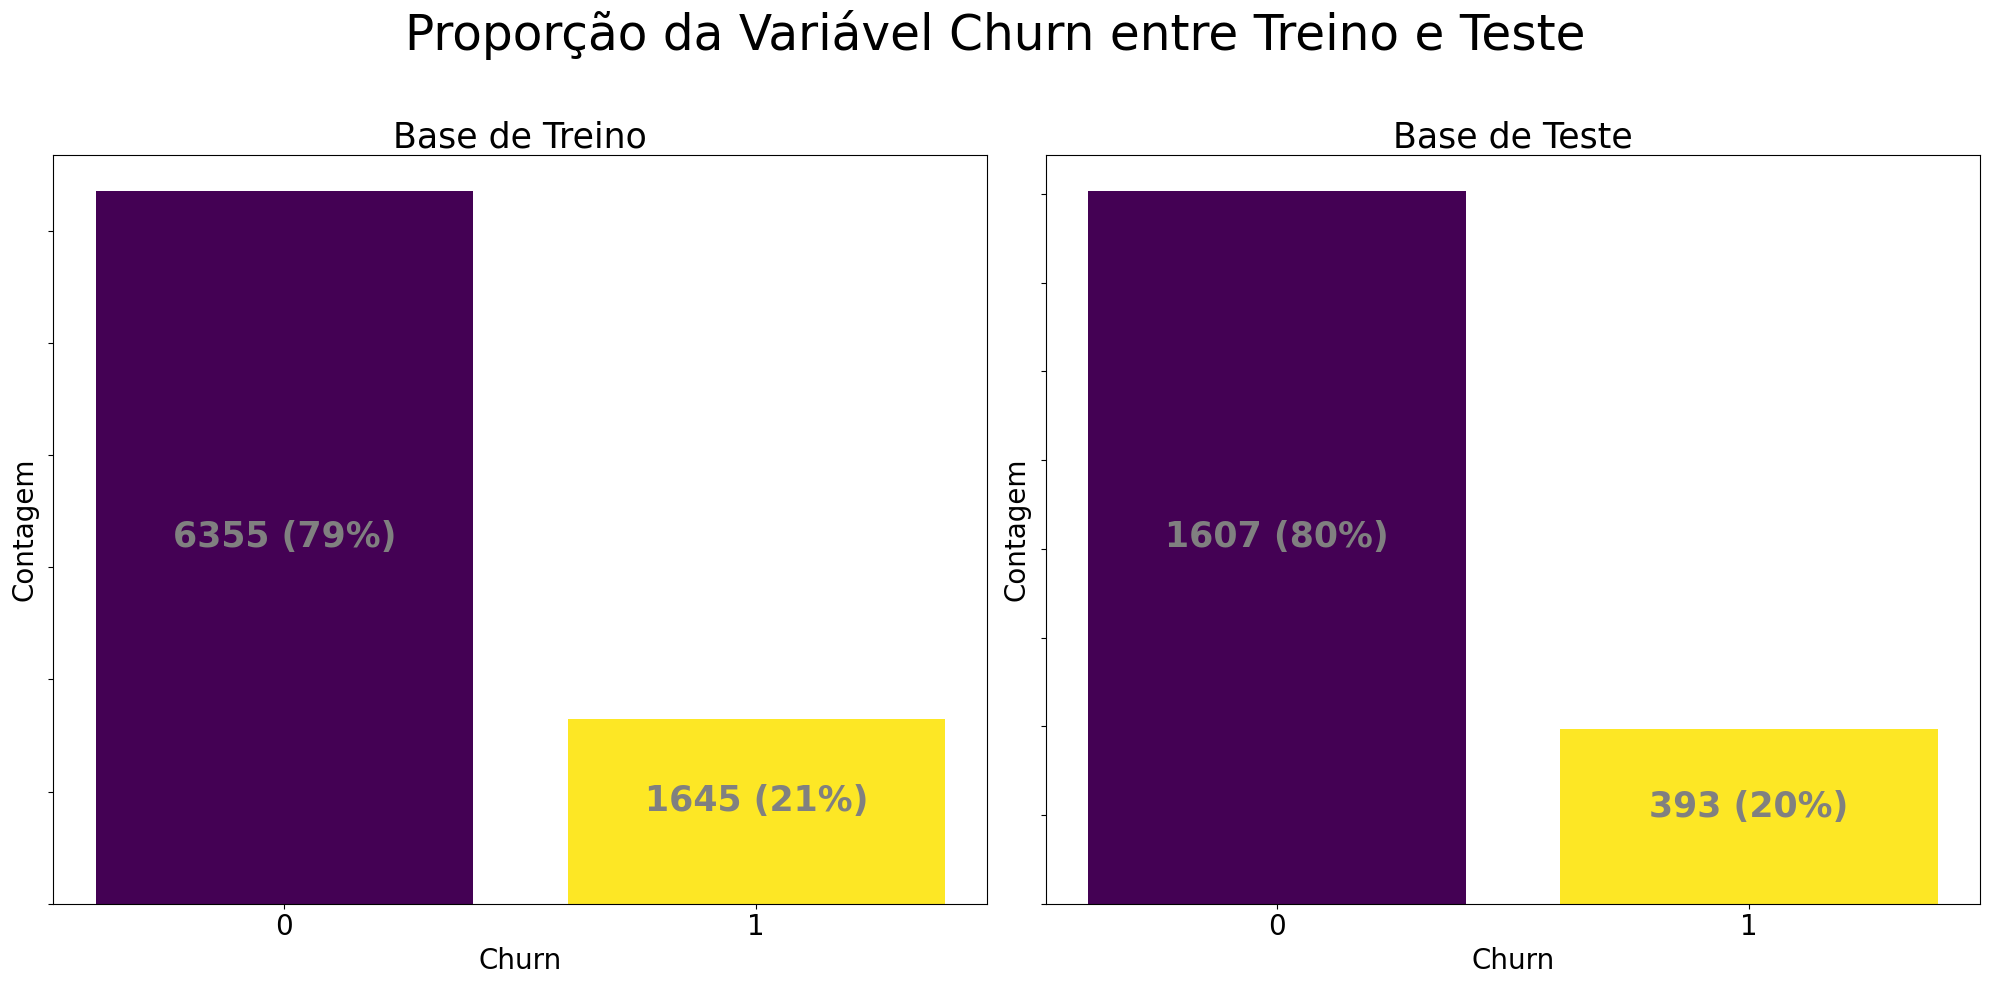

In [15]:
#X ---> Variáveis explicativas 
#Y ---> Evento de estudo (variável TARGET, evento de estudo, ^y etc..)



X = df_dummies .drop('Exited', axis=1)

# VARIAVEIS QUADRATICAS 
X['Balance_Squared'] = X['Balance'] ** 2
X['Age_Squared'] = X['Age'] ** 2
X['CreditScore_Squared'] = X['CreditScore'] ** 2
X['NumOfProducts_Squared'] = X['NumOfProducts'] ** 2
X['Tenure_Squared'] = X['Tenure'] ** 2
X['EstimatedSalary_Squared'] = X['EstimatedSalary'] ** 2



y =  df_dummies['Exited']


#separando em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Visualizando a proporção de eventos de churn (TARGET) nas bases de TREINO e TESTE 

# Contando os valores 
churn_counts_train = y_train.value_counts()
churn_counts_test = y_test.value_counts()


# Criando o plot 
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# Adicionando título 
fig.suptitle('Proporção da Variável Churn entre Treino e Teste', fontsize=35)
#definindo a paleta de cor 
cmap = plt.get_cmap('viridis', 2)



# Gráfico da base de treino
bars_train = axs[0].bar(churn_counts_train.index, churn_counts_train.values, color=cmap(range(2)))
axs[0].set_title('Base de Treino', fontsize=25)
axs[0].set_xlabel('Churn', fontsize=20)
axs[0].set_ylabel('Contagem', fontsize=20)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'], fontsize=20)
# Ocultando os valores do eixo y
axs[0].set_yticklabels([])

# Adicionando rótulos de dados nas barras da base de treino com valor absoluto e percentual
total_train = churn_counts_train.sum()
for bar in bars_train:
    count = int(bar.get_height())
    percentage = round(count / total_train * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  # Exibe o valor absoluto e o percentual
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')




# Gráfico da base de teste
bars_test = axs[1].bar(churn_counts_test.index, churn_counts_test.values, color=cmap(range(2)))
axs[1].set_title('Base de Teste', fontsize=25)
axs[1].set_xlabel('Churn', fontsize=20)
axs[1].set_ylabel('Contagem', fontsize=20)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['0', '1'], fontsize=20)
# Ocultando os valores do eixo y
axs[1].set_yticklabels([])

# Adicionando rótulos de dados nas barras da base de teste com valor absoluto e percentual
total_test = churn_counts_test.sum()
for bar in bars_test:
    count = int(bar.get_height())
    percentage = round(count / total_test * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  # Exibe o valor absoluto e o percentual
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')



# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deixa espaço para o título principal
plt.show()

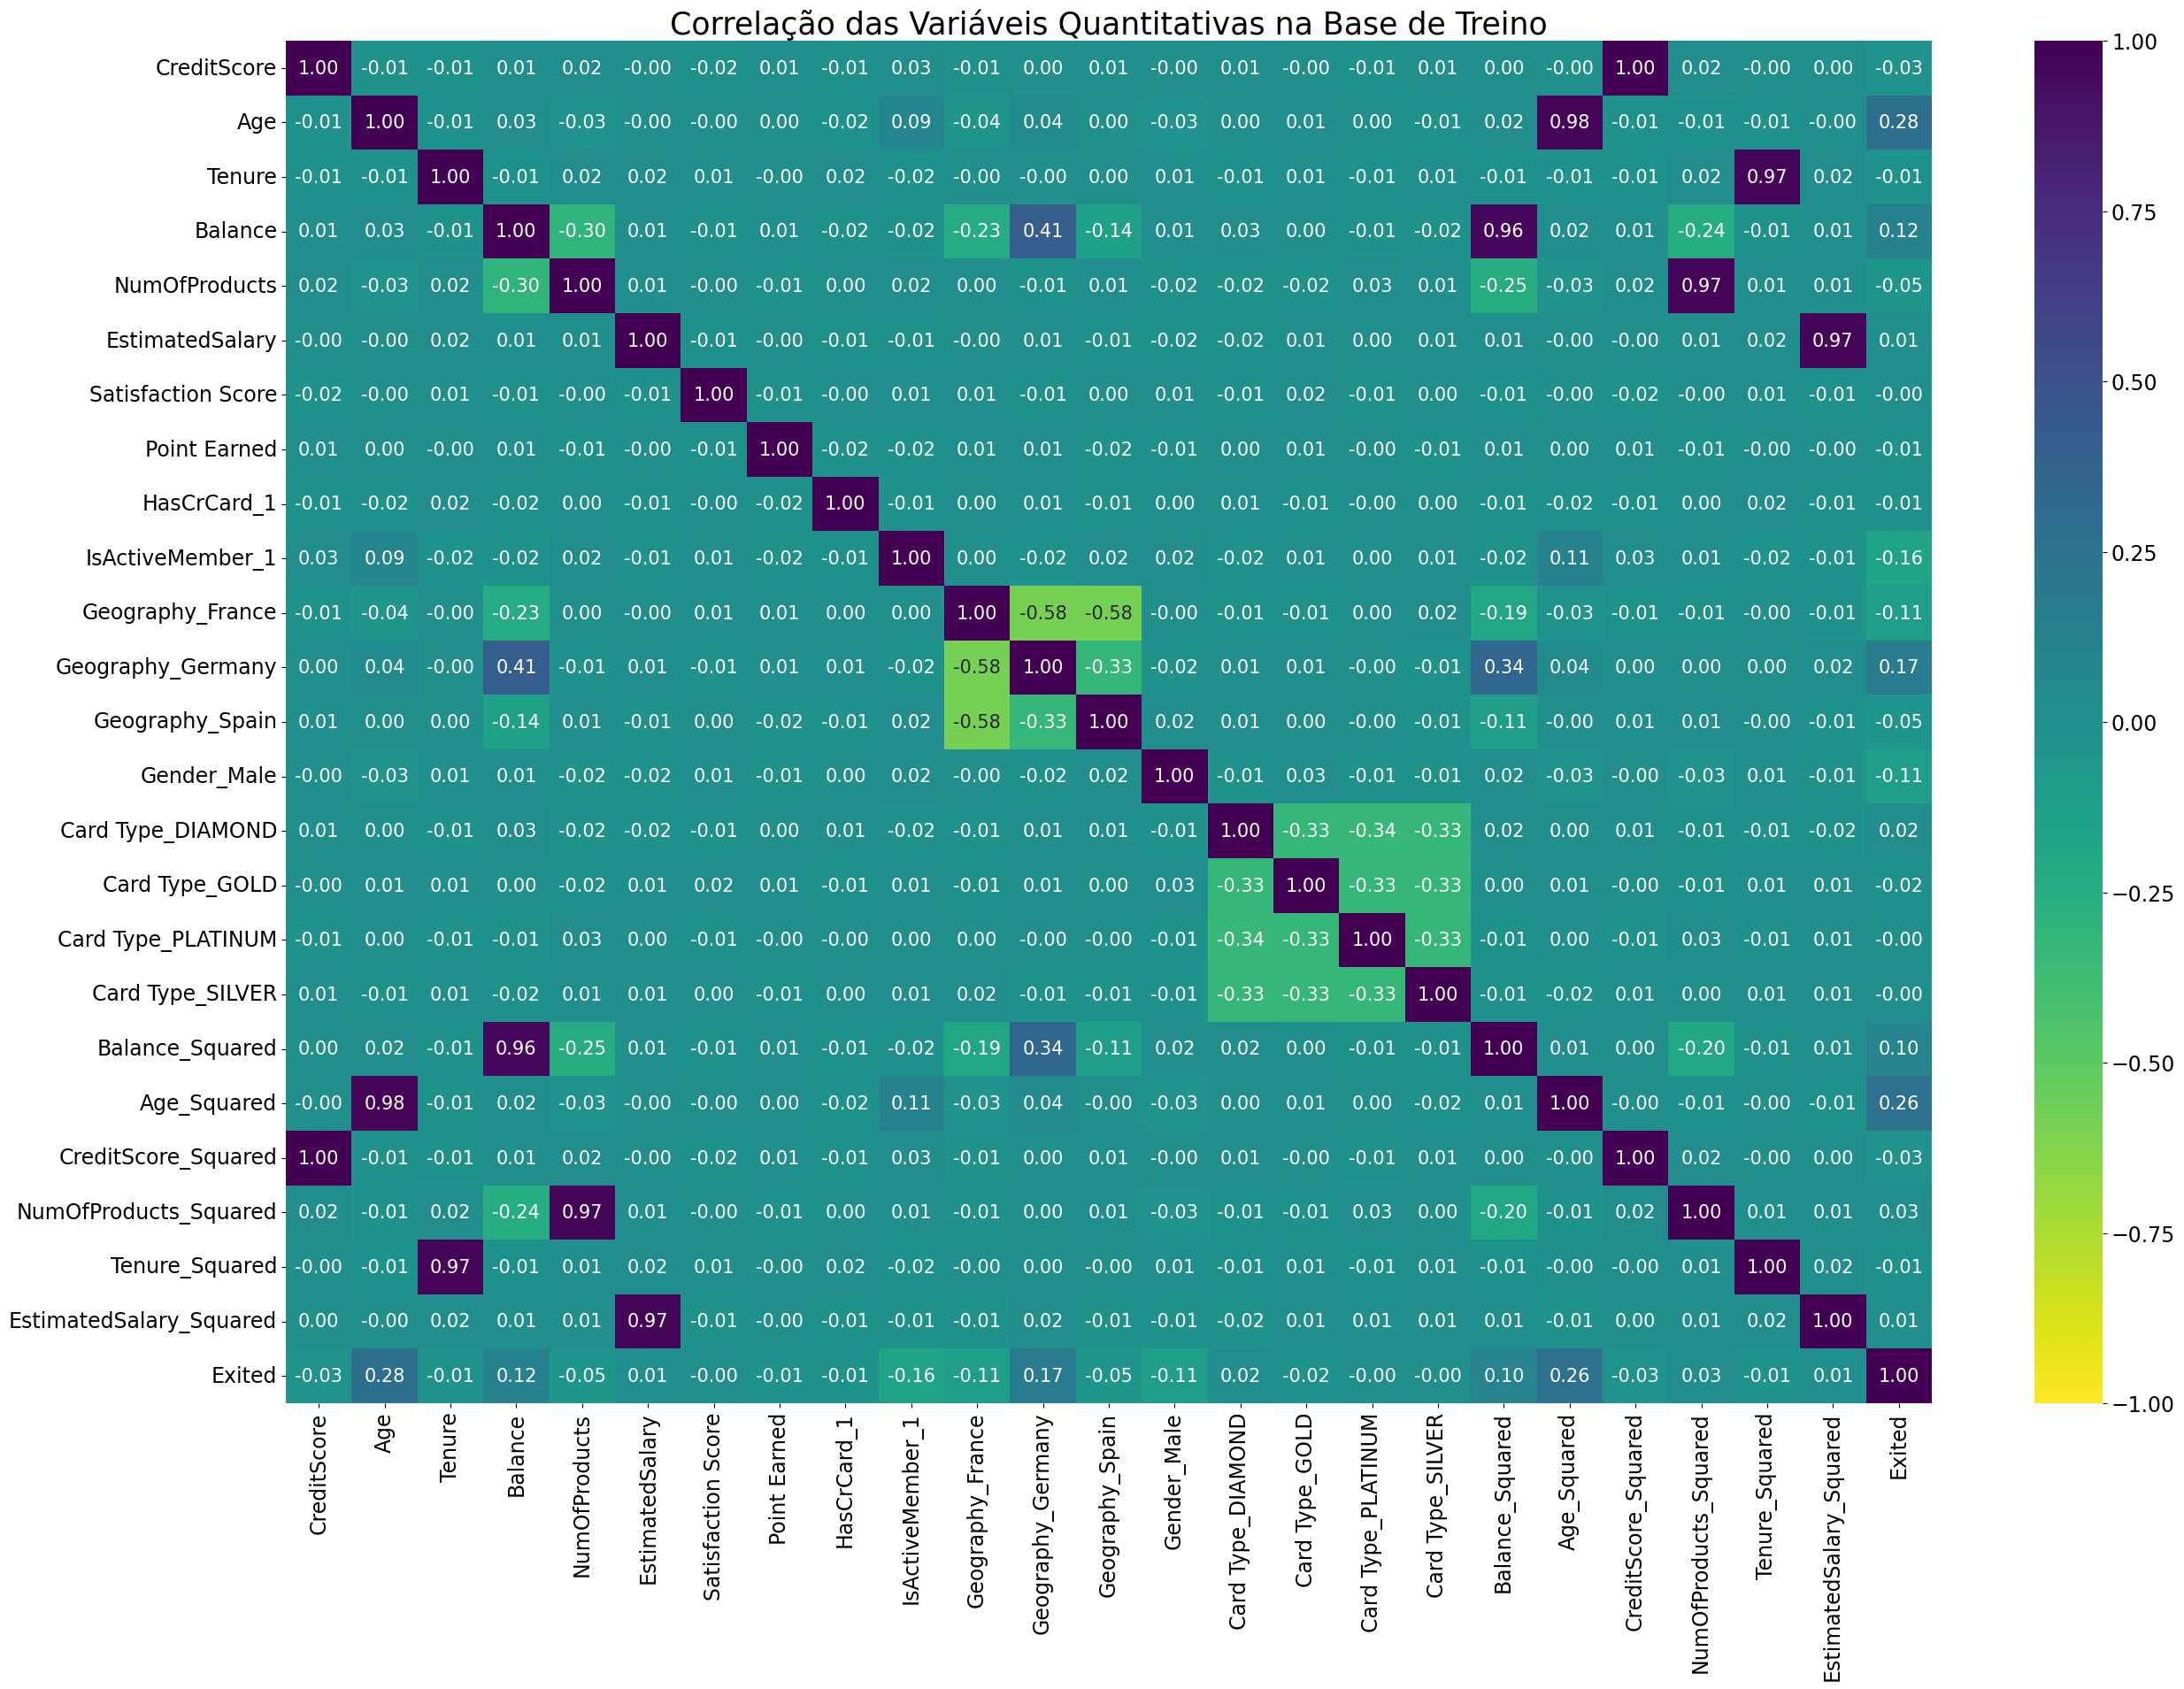

In [16]:
#Testando Multicolinearidade na base de treino

#as variaveis com alto correlacao foram removidas na primeira plotagem de matriz de corr, isso reduz o ruido no modelo

# todo esse processo de tirar as variaveis que tem alta correlacao com a variavel target deve ser analisado se realmente é necessario em cada cenario
# existem modelos que capturam bem isso e não são afetados pela multicolinearidade (pelo menos lidam bem) 

teste_multco_treino = pd.concat([X_train,y_train], axis = 1)

correlation_matrix_treino = teste_multco_treino.corr().round(2)
correlation_matrix_treino

# Matrix com  mapa de calor 
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix_treino, annot=True, fmt=".2f",
                      cmap=plt.cm.viridis_r, # paleta de cores viridis (ou viridis_r para o inverso de cores) é uma paleta especial 
                                             # para facilitar a visualizacao por pessoas com dificuldades visuais, como os daltonicos. 
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
plt.title('Correlação das Variáveis Quantitativas na Base de Treino',fontsize=25)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# Analise e tratamento de Outliers 

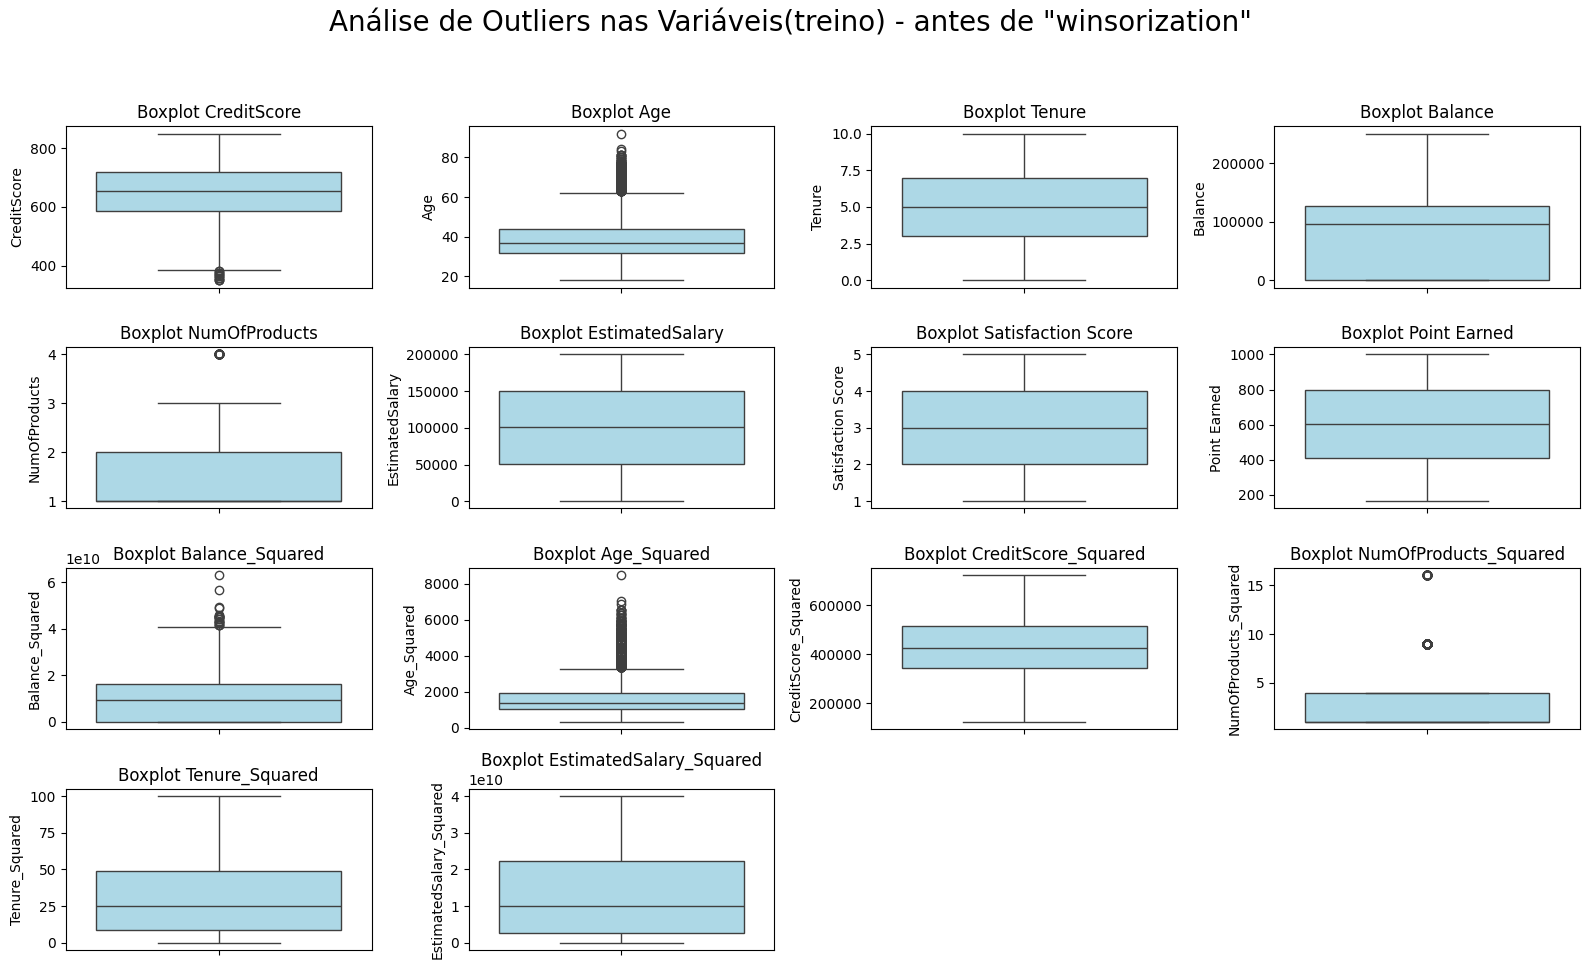

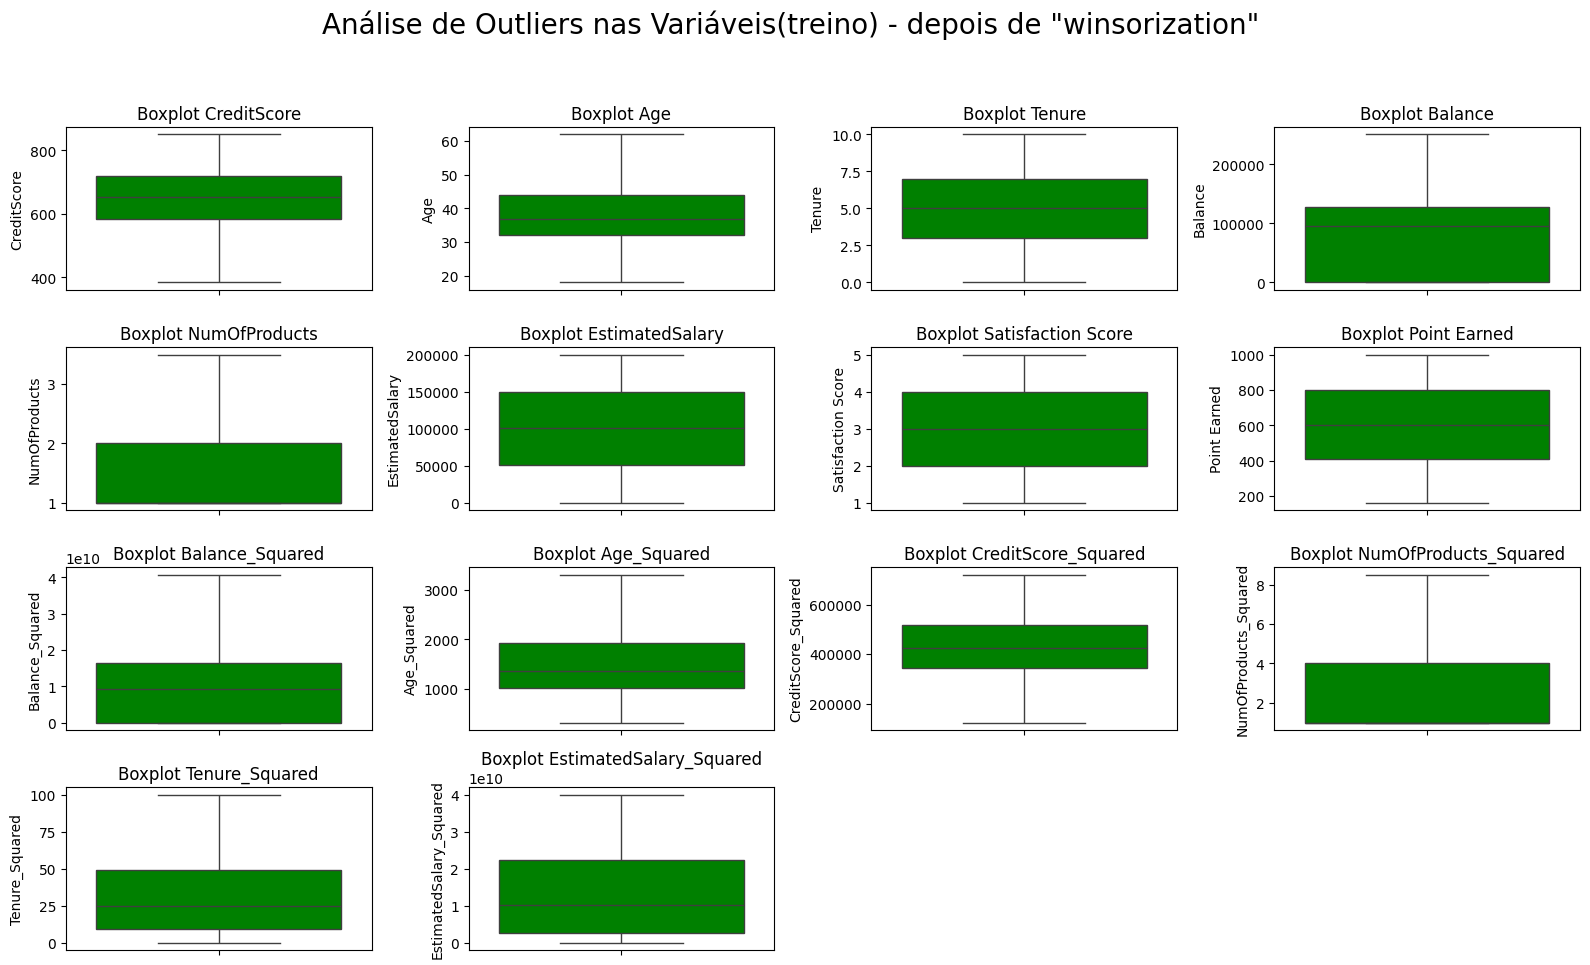

In [17]:
#%% analise de outliers das variaveis na base de treino 


#Outliers podem prejudicar MLPs, pois distorcem o treinamento e causam grandes gradientes, 
#o que pode dificultar a minimizacao da funcao de perda e levar a sobreajuste (overfitting). Isso afeta a capacidade de generalizacao do modelo. 
#é importante remover ou transformar outliers e usar tecnicas de regularizacao para mitigar isso 


#lembrando que isso so ocorre com variaveis numericas, vai ficar claro no barplot, onde poderemos ver as medidas de posicao 
variaveis = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'EstimatedSalary',
    'Satisfaction Score',
    'Point Earned',
    #INTERATIVAS MULTIPL
    #'Age_Balance_Interaction',
    #'NumOfProducts_Balance_Interaction'
    #QUADRATICAS
    'Balance_Squared',
    'Age_Squared',
    'CreditScore_Squared',
    'NumOfProducts_Squared',
    'Tenure_Squared',
    'EstimatedSalary_Squared'


]

# definindo tamenho dos subplots 
plt.figure(figsize=(16, 12))

# boxplots para cada variavel
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  # 3 linhas e 3 colunas
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='lightblue'))  # Cor interna do boxplot)  
    plt.title(f'Boxplot {var}', fontsize=12)
    
#  título
plt.suptitle('Análise de Outliers nas Variáveis(treino) - antes de "winsorization" ', fontsize=20)

# Ajuste de layout
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()



##aplicando procedimento de truncamento ou winsorization nas variaveis com outliers

#O procedimento de truncamento ou winsorization consiste em limitar os valores extremos de um conjunto de dados 
#(vai ficar claro nas duas aplicacoes de barplot a seguir ). 
#Para isso, e calculado um intervalo de valores aceitos com base no primeiro quartil (Q1) e no terceiro quartil (Q3)
#Valores abaixo do limite inferior ou acima do limite superior sao ajustados para os respectivos limites, corrigindo assim os outliers 
#"sem perda" dos dados originais


# Função que aplica winsorization
def tratar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Substitui outliers pelo limite inferior ou superior
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])



# Aplicando a função nas variáveis 
variaveis_para_tratar = ['Age', 
                         'CreditScore', 
                         'NumOfProducts',
                         #'Age_Balance_Interaction',
                         #'NumOfProducts_Balance_Interaction'
                        'Balance_Squared',
                        'Age_Squared',
                        'CreditScore_Squared',
                        'NumOfProducts_Squared',
                        'Tenure_Squared',
                        'EstimatedSalary_Squared'
                         ]
for variavel in variaveis_para_tratar:
    tratar_outliers(teste_multco_treino, variavel)


# subplot
plt.figure(figsize=(16, 12))



# boxplots separados para cada variável
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  # 3 linhas e 3 colunas
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='green'))  # Cor interna do boxplot)  # Usar o nome da variável diretamente
    plt.title(f'Boxplot {var}', fontsize=12)


# título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - depois de "winsorization" ', fontsize=20)


# Ajustando layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

In [18]:
#BASE DE TREINO 
teste_multco_treino

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,HasCrCard_1,IsActiveMember_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Balance_Squared,Age_Squared,CreditScore_Squared,NumOfProducts_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
9254,686.0,32.0,6,0.00,2.0,179093.26,2,510,1,1,1,0,0,1,1,0,0,0,0.000000e+00,1024.0,470596.0,4.0,36.0,3.207440e+10,0
1561,632.0,42.0,4,119624.60,2.0,195978.86,4,959,1,1,0,1,0,1,0,0,1,0,1.431004e+10,1764.0,399424.0,4.0,16.0,3.840771e+10,0
1670,559.0,24.0,3,114739.92,1.0,85891.02,4,327,1,0,0,0,1,1,0,0,0,1,1.316525e+10,576.0,312481.0,1.0,9.0,7.377267e+09,1
6087,561.0,27.0,9,135637.00,1.0,153080.40,2,567,1,0,1,0,0,0,0,0,0,1,1.839740e+10,729.0,314721.0,1.0,81.0,2.343361e+10,1
6669,517.0,56.0,9,142147.32,1.0,39488.04,3,727,0,0,1,0,0,1,0,0,1,0,2.020586e+10,3136.0,267289.0,1.0,81.0,1.559305e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,768.0,54.0,8,69712.74,1.0,69381.05,3,569,1,1,1,0,0,1,0,0,0,1,4.859866e+09,2916.0,589824.0,1.0,64.0,4.813730e+09,0
5191,682.0,58.0,1,0.00,1.0,706.50,4,709,1,1,1,0,0,0,0,0,1,0,0.000000e+00,3304.0,465124.0,1.0,1.0,4.991422e+05,0
5390,735.0,38.0,1,0.00,3.0,92220.12,5,678,0,0,1,0,0,0,0,0,0,1,0.000000e+00,1444.0,540225.0,8.5,1.0,8.504551e+09,1
860,667.0,43.0,8,190227.46,1.0,97508.04,3,680,1,0,1,0,0,1,1,0,0,0,3.618649e+10,1849.0,444889.0,1.0,64.0,9.507818e+09,1


In [19]:
# BASE DE TESTE
base_corrige_teste = pd.concat([X_test,y_test], axis = 1)
base_corrige_teste


,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,HasCrCard_1,IsActiveMember_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Balance_Squared,Age_Squared,CreditScore_Squared,NumOfProducts_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
6252,596,32,3,96709.07,2,41788.37,1,709,0,0,0,1,0,1,0,1,0,0,9.352644e+09,1024,355216,4,9,1.746268e+09,0
4684,623,43,1,0.00,2,146379.30,2,508,1,1,1,0,0,1,0,0,0,1,0.000000e+00,1849,388129,4,1,2.142690e+10,0
1731,601,44,4,0.00,2,58561.31,1,281,1,0,0,0,1,0,0,1,0,0,0.000000e+00,1936,361201,4,16,3.429427e+09,0
4742,506,59,8,119152.10,2,170679.74,2,979,1,1,0,1,0,1,0,0,0,1,1.419722e+10,3481,256036,4,64,2.913157e+10,0
4521,560,27,7,124995.98,1,114669.79,5,457,1,1,0,0,1,0,0,0,0,1,1.562400e+10,729,313600,1,49,1.314916e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,602,53,5,98268.84,1,45038.29,5,813,0,1,0,1,0,0,0,0,1,0,9.656765e+09,2809,362404,1,25,2.028448e+09,1
8285,609,25,10,0.00,1,109895.16,2,652,0,1,1,0,0,1,0,0,1,0,0.000000e+00,625,370881,1,100,1.207695e+10,0
7853,730,47,7,0.00,1,33373.26,2,504,1,0,1,0,0,0,0,0,1,0,0.000000e+00,2209,532900,1,49,1.113774e+09,1
1095,692,29,4,0.00,1,76755.99,3,686,1,0,1,0,0,1,0,0,1,0,0.000000e+00,841,478864,1,16,5.891482e+09,1


# Modelagem: aplicando MLP com Pytorch

O PyTorch é uma biblioteca de aprendizado profundo de código aberto, usada principalmente para o treinamento de redes neurais artificiais. Ele oferece flexibilidade e eficiência, permitindo a criação de modelos complexos e o treinamento acelerado com GPUs. O PyTorch é popular entre os pesquisadores devido à sua abordagem dinâmica de construção de grafos computacionais, facilitando a experimentação.

Para mais informações, você pode acessar a documentação oficial do PyTorch:
https://pytorch.org/docs/stable/


OBS: o uso de GPU precisa ser corrigido, a conversao dos tensores esta apresentando problemas. 
Visto isso, o codigo tambem executa em CPU, basta nao ativar a GPU (CUDA) que ele seleciona a CPU automaticamente.


Uma MLP (Multilayer Perceptron) é um tipo de rede neural artificial composta por múltiplas camadas de neurônios, usada principalmente para tarefas de classificação e regressão.


------------------------
MLP - Multi-Layer Perceptron 
------------------------
------------------------
Início: 2025-02-03 22:17:33.482447
------------------------
Índices de X_test e y_test já estavam alinhados.


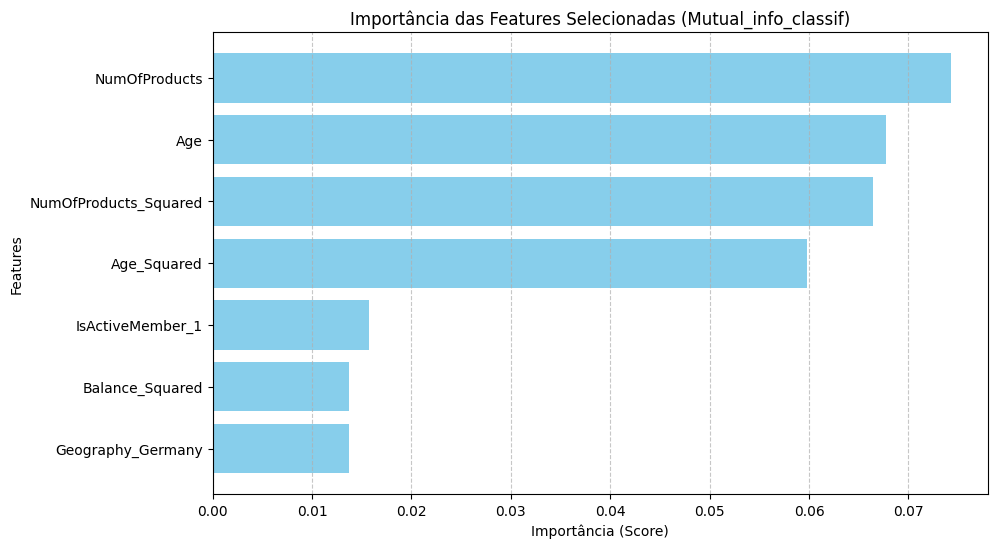

Dispositivo configurado: cuda


Processando tensores: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]

X_train_tensor shape: torch.Size([8000, 7]) | device: cuda:0
y_train_tensor shape: torch.Size([8000]) | device: cuda:0
X_test_tensor shape: torch.Size([2000, 7]) | device: cuda:0
y_test_tensor shape: torch.Size([2000]) | device: cuda:0


In [20]:
print('------------------------')
print("MLP - Multi-Layer Perceptron ")
print('------------------------')

# Desativando os warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
warnings.filterwarnings("ignore", category=UserWarning, module='optuna')
warnings.filterwarnings("ignore", category=FutureWarning, module='optuna')
warnings.filterwarnings('ignore', category=DeprecationWarning)
logging.getLogger("optuna").setLevel(logging.CRITICAL)



# início
start_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print('------------------------')


######################################## PRE-PROCESSAMENTO E PREPARACAO NOS DADOS ################################################################### 


# Definir as variáveis de treinamento
X_train = teste_multco_treino.drop('Exited', axis=1)
y_train = teste_multco_treino['Exited']

# Verifica e conserta desalinhamento de índices caso tenha (X_test e y_test)
if not X_test.index.equals(y_test.index):
    print("Índices de X_test e y_test não estavam alinhados. Realinhando y_test.")
    y_test = y_test.loc[X_test.index]
else:
    print("Índices de X_test e y_test já estavam alinhados.")

# Concatenar os dados corrigidos para criar a base de teste
base_corrige_teste = pd.concat([X_test, y_test], axis=1)

# Redefinir X_test e y_test com índices corrigidos e verificados
X_test = base_corrige_teste.drop('Exited', axis=1)
y_test = base_corrige_teste['Exited']




#classificacao e selecao de variaveis por teste de informações mútuas
#Ele calcula o valor de informação mútua para cada uma das variáveis ​​independentes com relação à variável dependente
#ele basicamente mede a dependência de recursos com o valor alvo


#selector = SelectKBest(score_func=mutual_info_classif, k='all') para verificar quantas e quais sao valores maiores que 0.01 (aqui cabe automatizacao depois)
selector = SelectKBest(score_func=mutual_info_classif, k=7) #seleciona depois de verificadas, a regra aqui foi de preferencialmente maiores de 0.1
X_train_selected = selector.fit_transform(X_train, y_train)

# Obter os índices das features selecionadas
selected_features_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_features_indices]  # Pegar os nomes das features selecionadas

# Obter os scores das features selecionadas
feature_scores = selector.scores_[selected_features_indices]

# Ordenar as features pelo score (do menor para o maior)
sorted_indices = np.argsort(feature_scores)  # Índices ordenados (crescente)
sorted_features = np.array(selected_features)[sorted_indices]
sorted_scores = feature_scores[sorted_indices]



#printando valores
# Criar DataFrame com os scores
#mi_df = pd.DataFrame({'Feature': selected_features, 'MI_Score': feature_scores})
# Ordenar pelo score (do menor para o maior)
#mi_df = mi_df.sort_values(by='MI_Score', ascending=True)
# Exibir os valores
#print(mi_df)




# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_scores, color='skyblue')
plt.xlabel('Importância (Score)')
plt.ylabel('Features')
plt.title('Importância das Features Selecionadas (Mutual_info_classif)')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Adicionar grid para melhor visualização

# Mostrar o gráfico
plt.show()

# Aplicar a seleção das mesmas features ao conjunto de teste
X_test_selected = X_test[selected_features].values  # Manter a ordem original



# Escalonamento dos dados
# Escolha do scaler (StandardScaler, MinMaxScaler, RobustScaler)
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()

# Escalonar os dados de treino e teste selecionados
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Configurar dispositivo para PyTorch (verifica a disponibilidade de GPU, caso contrário, usa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA ou CPU
# device = torch.device("cpu")  # Forçar uso da CPU, se necessário

print("Dispositivo configurado:", device)

# Agora você tem:
# X_train_scaled: Dados de treino selecionados e escalonados
# X_test_scaled: Dados de teste selecionados e escalonados
# y_train: Labels de treino
# y_test: Labels de teste


bar = tqdm(total=1, desc="Processando tensores", ncols=100, position=0) #barra de progresso plotada, ajuda a monitorar

# Convertendo para tensores PyTorch e movendo para o dispositivo
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)  
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)  

bar.update(1) #incrementa barra
bar.close()#fecha barra

# Verificando os shapes dos tensores depois de criados e dispositivo ativado em cada um, 
# para ter certeza da compatibilidade de processamento e tamanho
print(f"X_train_tensor shape: {X_train_tensor.shape} | device: {X_train_tensor.device}")
print(f"y_train_tensor shape: {y_train_tensor.shape} | device: {y_train_tensor.device}")
print(f"X_test_tensor shape: {X_test_tensor.shape} | device: {X_test_tensor.device}")
print(f"y_test_tensor shape: {y_test_tensor.shape} | device: {y_test_tensor.device}")

In [21]:
print('##########  MODELAGEM  ##################')

bar = tqdm(total=1, desc="Criando modelo", ncols=100, position=0)# Inicializando a barra de progresso


# classe MLP do modelo
class MLP(nn.Module):
    def __init__(self, hidden_layer_sizes, activation, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        input_size = X_train_tensor.shape[1]  
        for units in hidden_layer_sizes:
            self.layers.append(nn.Linear(input_size, units))
            self.layers.append(nn.Dropout(p=dropout_rate))  #dropout
            input_size = units
        self.output = nn.Linear(input_size, 1)  #Camada de saída
        self.activation_fn = self.get_activation_function(activation)
    
    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))  # Ativação após cada camada linear
        x = self.output(x)  
        return x

    def get_activation_function(self, activation):
        activation_dict = {
            'relu':torch.relu,
            'tanh':torch.tanh,
            'sigmoid':torch.sigmoid,
            'selu':torch.selu,
            'gelu':torch.nn.functional.gelu,
            'leaky_relu':torch.nn.functional.leaky_relu,
            'swish':torch.nn.functional.silu,
            'elu':torch.nn.functional.elu
        }
        return activation_dict.get(activation, torch.relu)  # Default e Relu so pra morrer de certeza que nao va da erro e a relu e a mais comum

bar.update(1)  
bar.close()



#Função que cria o modelo 
def create_model(
    hidden_layer_sizes,
    activation,
    solver,
    alpha,
    learning_rate_init,
    max_iter,
    batch_size,
    momentum,
    learning_rate_scheduler,
    weight_decay,
    step_size,
    gamma,
    early_stopping,
    validation_fraction,
    dropout_rate,
    patience,
    imbalance_ratio=1.0  
):

    # Calcular pesos da classe para aplicacao da funcao de peso para classe minoritaria (BCEWithLogitsLoss)
    count_neg = (y_train_tensor == 0).sum().item()  #classe 0
    count_pos = (y_train_tensor == 1).sum().item()  #classe 1
    pos_weight = torch.tensor([count_neg / count_pos], device=device)  # Ponderação para a classe minoritária
        
    # Instancia o modelo
    model = MLP(hidden_layer_sizes, activation, dropout_rate).to(device)
    
    # Funcao de perda com peso para a classe minoritária
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Configura o otimizador
    optimizers = {
        'adam': optim.Adam(model.parameters(), lr=learning_rate_init, weight_decay=weight_decay),
        'sgd': optim.SGD(model.parameters(), lr=learning_rate_init, momentum=momentum, weight_decay=weight_decay),
        'rmsprop': optim.RMSprop(model.parameters(), lr=learning_rate_init, weight_decay=weight_decay),
        'nadam': optim.NAdam(model.parameters(), lr=learning_rate_init, weight_decay=weight_decay),
        'lbfgs': optim.LBFGS(model.parameters(), lr=learning_rate_init, max_iter=20, history_size=10)
    }
    optimizer = optimizers.get(solver, optim.Adam(model.parameters(), lr=learning_rate_init, weight_decay=weight_decay))
    
    # Configura o scheduler
    schedulers = {
        'StepLR': lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma),
        'CosineAnnealingLR': lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iter),
        'ReduceLROnPlateau': lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=15, verbose=True),
        'CosineAnnealingWarmRestarts': lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2),
        'ExponentialLR': lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    }

    scheduler = schedulers.get(learning_rate_scheduler, None)

    return model, criterion, optimizer, scheduler



# Função para salvar o melhor modelo ('torch.save')
def save_best_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Modelo salvo em {filepath}")







#############################################################Função objetivo para o Optuna#######################################################################

#O Optuna e semelhante ao Gridsearch, costuma ser mais performatico e ate melhor em busca
bar = tqdm(total=1, desc="Criando hiperparametros Optuna E validação cruzada", ncols=100, position=0) 

bar2=None
def objective(trial):
    #print("Iniciando o trial", trial.number)
    global bar2
    try:

        #Hiperparametros 
        hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(900, 800), (950,850),(975,875),(990,890),(1000,900) ])
        activation = trial.suggest_categorical('activation', ['leaky_relu', 'swish', 'gelu', 'relu', 'elu', 'selu', 'tanh'])
        solver = trial.suggest_categorical('solver', ['nadam', 'adam', 'sgd', 'rmsprop', 'lbfgs'])
        alpha = trial.suggest_loguniform('alpha', 3e-4, 5e-4)  
        learning_rate_init = trial.suggest_loguniform('learning_rate_init', 8e-5, 1.2e-4)  
        max_iter = trial.suggest_categorical('max_iter', [5000, 6000, 8000, 10000])  
        batch_size = trial.suggest_categorical('batch_size', [512, 1024])  
        momentum = trial.suggest_uniform('momentum', 0.7, 0.75)  
        learning_rate_scheduler = trial.suggest_categorical('learning_rate_scheduler', ['ReduceLROnPlateau'])   
        weight_decay = trial.suggest_loguniform('weight_decay', 5e-4, 8e-4)  
        step_size = trial.suggest_int('step_size', 30, 40)  
        gamma = trial.suggest_uniform('gamma', 0.65, 0.7)  
        early_stopping = trial.suggest_categorical('early_stopping', [True])   
        validation_fraction = trial.suggest_uniform('validation_fraction', 0.25, 0.3)  
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.4)  
        patience = trial.suggest_int('patience', 15, 20)   


                
        # Cria modelo ja inserindo os hiperparametros do Optuna
        model, criterion, optimizer, scheduler = create_model(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            batch_size=batch_size,
            momentum=momentum,
            learning_rate_scheduler=learning_rate_scheduler,
            weight_decay=weight_decay,
            step_size=step_size,
            gamma=gamma,
            early_stopping=early_stopping,
            validation_fraction=validation_fraction,
            dropout_rate=dropout_rate,
            patience=patience)
        
        
        # Função de treinamento e validação cruzada
        def train_and_evaluate_cross_validation(epochs, patience):
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            auc_scores = []
            recall_scores = []
            f1_scores = []
            
            adasyn = ADASYN(random_state=42)
            
            device = next(model.parameters()).device  #modelo e dados estão no mesmo dispositivo

            model.to(device)

            for train_index, val_index in skf.split(X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy()):
                X_train_cv, X_val_cv = X_train_tensor[train_index].to(device), X_train_tensor[val_index].to(device)
                y_train_cv, y_val_cv = y_train_tensor[train_index].to(device), y_train_tensor[val_index].to(device)

                X_train_cv_res, y_train_cv_res = adasyn.fit_resample(X_train_cv.cpu().numpy(), y_train_cv.cpu().numpy())

                X_train_cv_res = torch.tensor(X_train_cv_res).float().to(device)
                y_train_cv_res = torch.tensor(y_train_cv_res).float().to(device)

                train_dataset = TensorDataset(X_train_cv_res, y_train_cv_res)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                # Implementação de early stopping
                best_val_loss = float('inf')
                patience_counter = 0
                for epoch in range(epochs):
                    model.train()
                    for X_batch, y_batch in train_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        optimizer.zero_grad()
                        output = model(X_batch).squeeze()
                        loss = criterion(output, y_batch)
                        loss.backward()

                        # Condicional para o solver 'lbfgs'
                        if solver == 'lbfgs':
                            def closure():
                                optimizer.zero_grad()
                                loss = criterion(model(X_batch).squeeze(), y_batch)
                                loss.backward()
                                return loss
                            optimizer.step(closure)
                        else:
                            optimizer.step()

                    model.eval()
                    with torch.no_grad():
                        val_preds = model(X_val_cv).squeeze()  # Mantendo no dispositivo CUDA
                        val_labels = y_val_cv
                        val_loss = criterion(val_preds, val_labels).item()
                        
                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            patience_counter = 0
                        else:
                            patience_counter += 1
                        if patience_counter >= patience:
                            break

                    model.eval()
                    with torch.no_grad():
                        val_logits = model(X_val_cv).squeeze()  
                        val_labels = y_val_cv

                        # Função sigmoide para obter as probabilidades
                        val_preds = torch.sigmoid(val_logits)

                        threshold = 0.5
                        val_preds_binary = (val_preds > threshold).float()

                        #calcular métricas com scikit-learn, tensores movidos para a CPU e numpy
                        val_preds_cpu = val_preds_binary.cpu().numpy()
                        val_labels_cpu = val_labels.cpu().numpy()
                        auc = roc_auc_score(val_labels_cpu, val_preds_cpu)
                        recall = recall_score(val_labels_cpu, val_preds_cpu)
                        f1 = f1_score(val_labels_cpu, val_preds_cpu)

                        # guardando métricas
                        auc_scores.append(auc)
                        recall_scores.append(recall)
                        f1_scores.append(f1)

            return np.mean(auc_scores), np.mean(recall_scores), np.mean(f1_scores)


        
        #validação cruzada
        mean_auc, mean_recall, mean_f1 = train_and_evaluate_cross_validation(epochs=100, patience=15)

        
        #métrica composta para otmizacao do modelo
        score = 0.85 * mean_auc + 0.15 * mean_recall
        
        # resultados ao Optuna
        trial.report(score, 0)  #  step 0
        trial.report(mean_recall, 1)  #step 1
        trial.report(mean_f1, 2)     #  step 2
        
        if trial.should_prune():
            print(f"Trial {trial.number} foi interrompido devido ao pruning.")
            raise optuna.exceptions.TrialPruned()
        
        # Salvando o modelo no trial para ser acessado após a otimização
        trial.set_user_attr('model', model)
        
        
        bar2.update(1)
        
        # Retorna a métrica composta
        
        return score 
    
    except Exception as e:
        import traceback
        
        # Captura o tipo de erro e a mensagem de erro
        error_type = type(e).__name__
        error_message = str(e)
        
        # Captura o traceback completo para mais detalhes
        error_traceback = traceback.format_exc()

        # Exibe o erro completo no console
        print(f"Erro específico encontrado: {error_type} - {error_message}")
        print("Traceback completo:")
        print(error_traceback)
        
        # Atualiza a barra de progresso após o erro (se necessário)
        # bar2.update(1)
        
        # Retorna valor negativo infinito para continuar a otimização
        return float('-inf')

     
    # Salvar o modelo após a otimização
    torch.save(model.state_dict(), 'best_model.pth') #salva apenas os parametros 

    
bar.update(1)
bar.close()  # Fechar a barra

import joblib





print('########################################Definindo o estudo do Optuna############################################################')

#otimização bayesiana baseado em Tree-structured Parzen Estimators (TPE)

#O TPESampler é semelhante ao GridSearch, mas em vez de testar exaustivamente todas as combinações possíveis de hiperparâmetros, 
#ele utiliza uma abordagem probabilística para explorar de forma mais eficiente o espaço de busca e maximizar a função objetivo.


#Depois de encontrados lugares/lugar otimo nos hiperparametros e ruduzir o range de estudo deles, aplicar abordagem de maximizacao (exploitation)
sampler_ = optuna.samplers.TPESampler(
    n_startup_trials=20,      # Define o número de tentativas iniciais aleatórias antes de usar o algoritmo TPE
    n_ei_candidates=7,       # Número de candidatos gerados pelo TPE antes de escolher o melhor.
    seed=42,                  # semente, Define um número fixo para o gerador de números aleatórios.
    multivariate=True,        # Considera correlação entre hiperparâmetros
    group=True,               # Melhor para alta dimensionalidade (>10 parâmetros)
    consider_magic_clip=False # Mantém como False para não limitar artificialmente
)





n_trials = 50
bar2 = tqdm(total=n_trials, desc="Otimização em andamento", ncols=100, position=0)

study = optuna.create_study(direction="maximize",sampler=sampler_) 
study.optimize(objective, n_trials=n_trials)

best_model = study.best_trial.user_attrs['model']

# Salvando o melhor modelo otimizado
save_best_model(best_model, 'best_model.pth')

# Resultados
best_params = study.best_params
print(f"Melhores parâmetros: {best_params}")

bar2.close()
bar.close()

print('########################################FIM do estudo do Optuna############################################################')

##########  MODELAGEM  ##################


Criando modelo: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
Criando hiperparametros Optuna E validação cruzada: 100%|█████████████████████| 1/1 [00:00<?, ?it/s]


########################################Definindo o estudo do Optuna############################################################


Otimização em andamento: 100%|██████████████████████████████████████| 50/50 [54:58<00:00, 65.96s/it]

Modelo salvo em best_model.pth
Melhores parâmetros: {'hidden_layer_sizes': (1000, 900), 'activation': 'relu', 'solver': 'nadam', 'alpha': 0.00034716344264496316, 'learning_rate_init': 9.877062447974513e-05, 'max_iter': 10000, 'batch_size': 512, 'momentum': 0.7298342536977355, 'learning_rate_scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.0006059162972013002, 'step_size': 39, 'gamma': 0.6994889417158945, 'early_stopping': True, 'validation_fraction': 0.2572225775111612, 'dropout_rate': 0.3254104375117066, 'patience': 18}
########################################FIM do estudo do Optuna############################################################


########### Treinamento final ##############: 100%|███████████████| 100/100 [13:19<00:00,  8.00s/it]


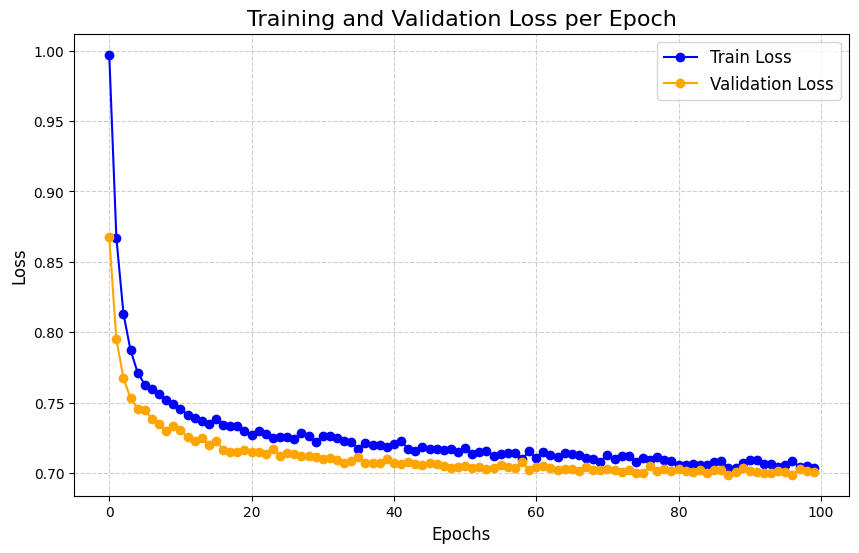

###########################Treinamento final concluído com sucesso!######################################
Menor perda de validação: 0.6989
###########################Avaliando no conjunto de teste!######################################
ROC AUC (Teste): 0.8653
Acurácia (Teste): 0.7940
Precisão (Teste): 0.4849
Recall (Teste): 0.7761
F1-Score (Teste): 0.5969


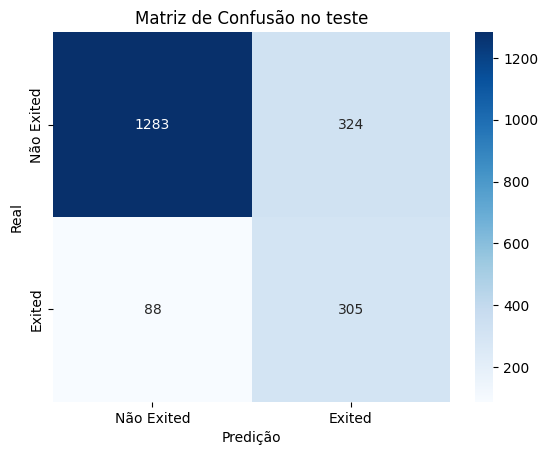

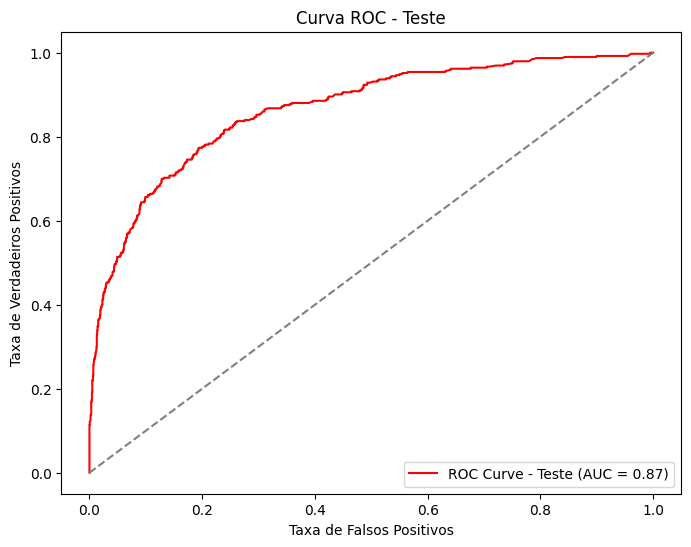

In [22]:

# Inicializando a barra de progresso
epochs = 100 #quantidade de epocas
bar = tqdm(total=epochs, desc="########### Treinamento final ##############", ncols=100, position=0)

X = X[selected_features] # selected_features já foi definido antes com ANOVA no comeco do modelo (sao as variaveis selecionadas com o ANOVA)

# Divisão dos dados 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização garantindo que o scaler do treino seja usado na validação
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Ajusta no treino
X_val = scaler.transform(X_val)  # Transforma no conjunto de validação com os mesmos parâmetros

# Convertendo os dados para tensores 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Criando tensores de treinamento e validação
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Criando os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=4)




# Função de treinamento de uma época (modelo ja esta treinado)
def train_one_epoch(model, train_loader, optimizer, criterion, device, scheduler=None):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Clipping de gradientes para evitar explosão
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    if scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()
    
    return epoch_loss



# Função de validação
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    return val_loss / len(val_loader.dataset)



# Inicializando o modelo, otimizador e scheduler
model, criterion, optimizer, scheduler = create_model(**best_params)
model.to(device)  # Movendo o modelo para o dispositivo (GPU ou CPU)



# armazenar as perdas em listas
train_losses = []
val_losses = []
best_loss = float('inf')

# Loop de treinamento final
for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, scheduler)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Ajuste do scheduler com a perda de validação, se aplicável
    if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(val_loss)

    # Salvando o melhor modelo
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth") #aqui salva o OrderedDict (sopmente os parametros, bom pra usar no mesmo codigo enquanto reina e testa o 80/20)
        torch.save(model, 'best_model_inteiro.pth') #salva o modelo INTEIRO com dict e tudo, bom para aplicar o modelo em producao
        torch.save(scaler, 'scaler.pth')  # Salvar scaler usado no treino


    bar.update(1)

bar.close()

# Carregar o melhor modelo após o treinamento
model.load_state_dict(torch.load("best_model.pth"))





# Plotando as perdas por época
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='-', marker='o')
plt.title('Training and Validation Loss per Epoch', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("###########################Treinamento final concluído com sucesso!######################################")
print(f"Menor perda de validação: {best_loss:.4f}")



# Avaliação final
print("###########################Avaliando no conjunto de teste!######################################")
# Carregando o melhor modelo
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


# Avaliando no conjunto de teste
with torch.no_grad():
    y_pred_logits = model(X_test_tensor.to(device)).cpu().numpy().squeeze()  # logits
    y_pred_prob_test = torch.sigmoid(torch.tensor(y_pred_logits)).cpu().numpy()  # Aplicando a sigmoide para obter probabilidades



#threshold 
# Fixando o threshold em 0.5
threshold = 0.5
y_pred_class_test = (y_pred_prob_test > threshold).astype(int)



# Calculando métricas e exibindo métricas
roc_auc = roc_auc_score(y_test, y_pred_prob_test)
accuracy = accuracy_score(y_test, y_pred_class_test)
precision = precision_score(y_test, y_pred_class_test)
recall = recall_score(y_test, y_pred_class_test)
f1 = f1_score(y_test, y_pred_class_test)
print(f"ROC AUC (Teste): {roc_auc:.4f}")
print(f"Acurácia (Teste): {accuracy:.4f}")
print(f"Precisão (Teste): {precision:.4f}")
print(f"Recall (Teste): {recall:.4f}")
print(f"F1-Score (Teste): {f1:.4f}")



#matriz de confusao
conf_matrix = confusion_matrix(y_test, y_pred_class_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Exited', 'Exited'], yticklabels=['Não Exited', 'Exited'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão no teste')
plt.show()





# Cálculo da curva ROC para o conjunto de teste
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)
# Gráfico ROC teste
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', label=f'ROC Curve - Teste (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC - Teste')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()


################FAZENDO PREDIÇÕES SIMULANDO UMA APLICAÇÃO EM PRODUÇÃO EM DADOS NOVOS ##############################


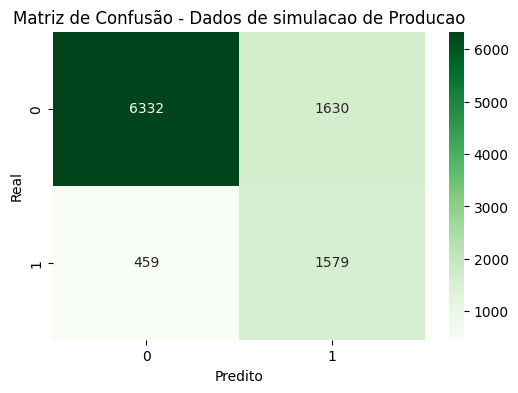

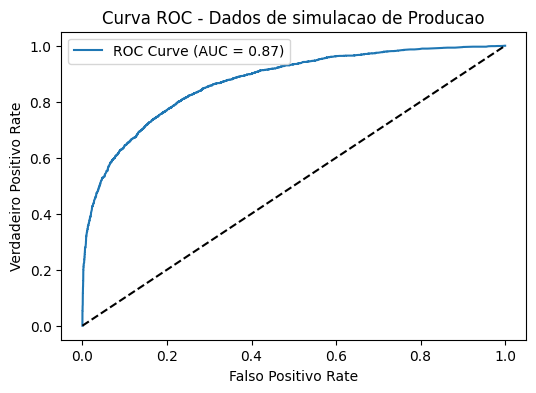

Acurácia total - Dados de simulacao de Producao: 79.11%
Recall da classe positiva - Dados de simulacao de Producao: 77.48%
------------------------
Início: 2025-02-03 22:17:33.482447
Fim:    2025-02-03 23:25:53.020687
------------------------


In [23]:
print('################FAZENDO PREDIÇÕES SIMULANDO UMA APLICAÇÃO EM PRODUÇÃO EM DADOS NOVOS ##############################')


# Carregar o modelo treinado inteiro e em modo de avaliação
model = torch.load('best_model_inteiro.pth')
model.eval()

# Carregar o scaler utilizado no treinamento
scaler = torch.load('scaler.pth')

# Carregar os novos dados concatenando treino e teste
df_new = pd.concat([base_corrige_teste,teste_multco_treino], axis = 0)

#df_new = df_new.head(5000) # para testar em apenas 5000 observações

# Selecionar as mesmas features utilizadas no treinamento (via ANOVA)
X_new = df_new[selected_features]  

# Separar as labels (y) e features (X)
y_true = df_new['Exited'].values  # Valores reais para avaliação

# Aplicar o mesmo pré-processamento (normalização) nos novos dados
X_scaled = scaler.transform(X_new)

# Converter para tensor PyTorch
input_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Mover o tensor de entrada e o modelo para o mesmo dispositivo (GPU ou CPU)
input_tensor = input_tensor.to(device)  # Certifique-se de que input_tensor está no mesmo dispositivo do modelo


# Obter predições do modelo
with torch.no_grad():
    y_pred_logits = model(input_tensor)  # Logits previstos
    y_pred_prob = torch.sigmoid(y_pred_logits)  # Aplicando sigmoide para obter probabilidades

# Converter para numpy (certifique-se de mover para CPU se estiver na GPU)
y_pred_logits = y_pred_logits.cpu().numpy()
y_pred_prob = y_pred_prob.cpu().numpy()

# Converter probabilidades em classes (0 ou 1)
y_pred_class = (y_pred_prob > 0.5).astype(int)



# Calcular  e vusualizar matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Dados de simulacao de Producao')
plt.show()

# Calcular e plotar curva ROC AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Verdadeiro Positivo Rate')
plt.title('Curva ROC - Dados de simulacao de Producao')
plt.legend()
plt.show()



# Calcular a acurácia total
accuracy_positive = accuracy_score(y_true, y_pred_class)
print(f"Acurácia total - Dados de simulacao de Producao: {accuracy_positive * 100:.2f}%")

# Calcular o recall da classe positiva
positive_class_recall = recall_score(y_true, y_pred_class)
print(f"Recall da classe positiva - Dados de simulacao de Producao: {positive_class_recall * 100:.2f}%")




# Fim
end_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print("Fim:   ", end_time_utc)
print('------------------------')